# Entendiendo los parámetros de nuestras redes neuronales

En esta tarea se va a profundizar en el análisis de los parámetros más improtantes de las redes neuronales desde los parámetros de las capas empleadas, parámetros generales de entrenamiento (batch size, epochs, learning rate...) y parámetros de entrneamiento como optimizadores y funciones de Loss. Para ello el notebook se divide en tres partes dónde trataremos 3 tipos de redes de las más comunes como son las redes de neuronas totalmente conectadas profundas (DNN), las redes convolucionales (CNN) y las redes recurrentes (RNN). Para todas ellas se proprociona un código simpel de entrenamiento sobre el dataset FashionMnist que es un dataset d eimágenes muy sencillo con imágenes de prendas de ropa en escala de grises de tamaño 28x28. Utilizaremos estos datos como entrada a nuestras redes. Una vez analizado el ejemplo se proponen una serie de preguntas generales sobre los distintos parámetros de las redes que debe responder en detalle en los apartados proprocionados para ello. Junto a algunas preguntas se propone que reutilice el código proporcionado modificando los parámetros que se piden en cada caso para comparar los resultados con los proprocionados en el ejemplo. La idea es comentar finalmente con las implementaciones que añada una celda de texto que comente los resultados de manera general y que justifiquen su respuesta anterior a la pregunta proprocionada.

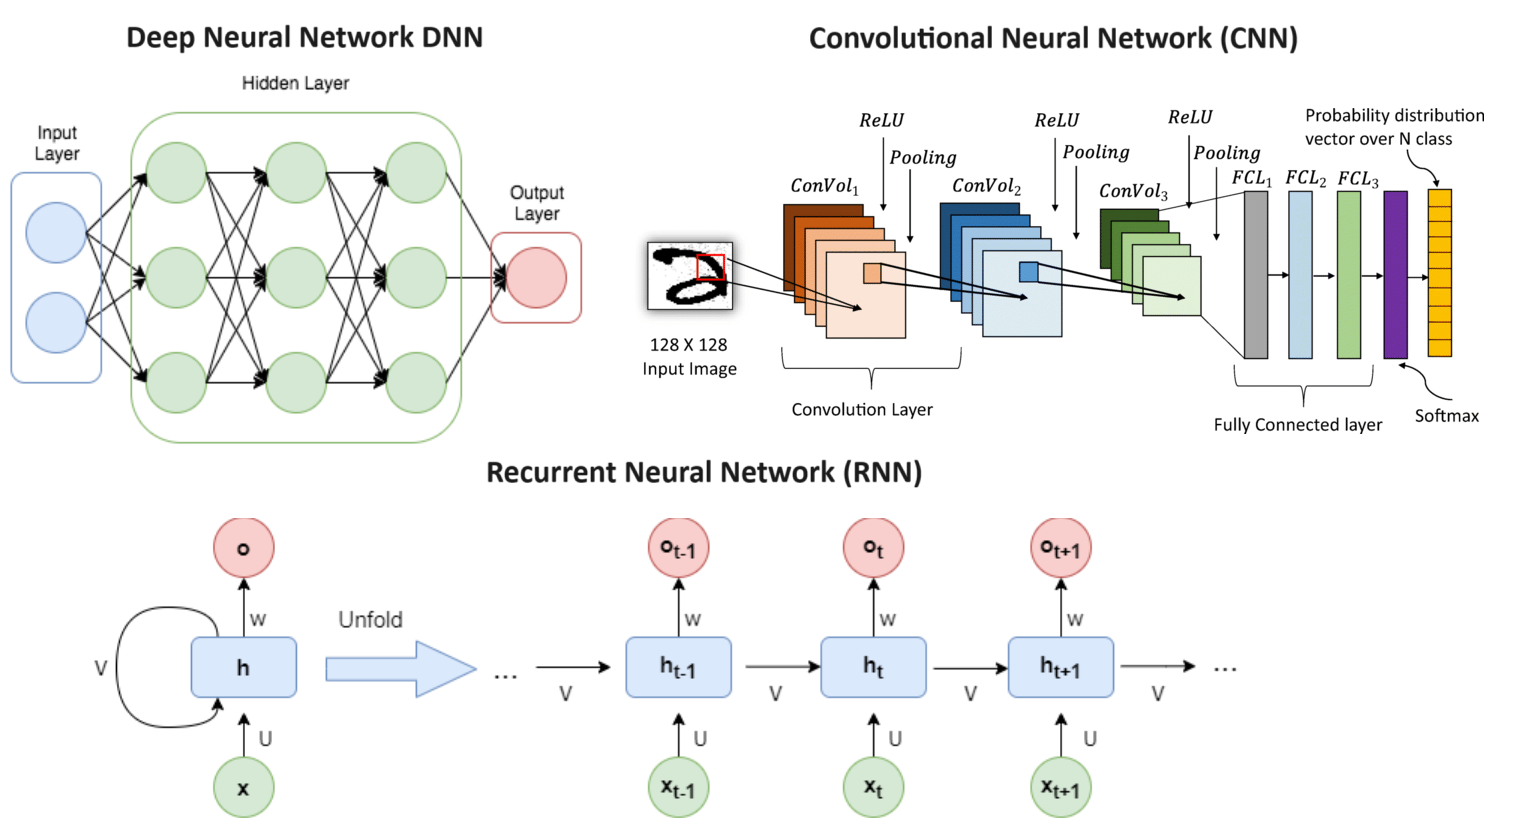

Nota 1: Tenga en cuenta que no en todos los casos deben cumplirse las espectativas que deberían suceder de manera general. Por ejemplo, si cambia el optimizador de SGD a ADAM debería llegarse a un resultado de accuracy más alto con el mismo número de epochs (pero en otros casos puede que no suceda exactamente lo que se espera o que los resultados sean muy parecidos debido a la naturaleza tan simple del problema propuesto).

Nota 2: Las 5 primeras celdas de código proporcionadas continen por un lado las librerías que necesitará para el proyecto, por otro lado la carga del dataset a usar separándolo entrenamiento y test, un ejemplo para que vea las imágenes originales, una línea para seleccionar si hay o no GPU disponible y el bucle de entrenamiento y test d ela red. Si trabaja en colab puede trabajar mucho más rápido si activa el entorno con GPU. No modifique estas líneas y emplee en todo momento estas definiciones en sus experimentos. Sólo debe cambiar las redes y otros parámetros que se proporcionan en las demás celdas.

Nota 3: El conjunto de entrenamiento y test originales contienen 60000 y 10000 imágenes respectivamente. Dado que queremos realziar experimentos de manera rápida se ha reducido el dataset de entrenamiento a un 10% del tamaño original manteniendo el número de clases independientes similar y el conjunto de test se ha reducido a la mitad. Trabaje en todo momento con estos conjuntos reducidos ya proporcionados sin modificar nada.

# DNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Cargar el dataset completo
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Obtener las etiquetas para el muestreo estratificado
targets = full_train_dataset.targets.numpy()

# Definir el tamaño del subconjunto y obtener índices estratificados
subset_size = 0.1  # por ejemplo, 10% del dataset completo
_, class_counts = np.unique(targets, return_counts=True)
n_samples_per_class = int(subset_size * class_counts.min())

# Obtener índices estratificados
stratified_indices = []
for class_label in np.unique(targets):
    class_indices = np.where(targets == class_label)[0]
    class_subset_indices = np.random.choice(class_indices, n_samples_per_class, replace=False)
    stratified_indices.extend(class_subset_indices)

# Crear el dataset reducido manteniendo la distribución de clases
stratified_subset = torch.utils.data.Subset(full_train_dataset, indices=stratified_indices)

# Crear DataLoader para el subset
train_loader = torch.utils.data.DataLoader(stratified_subset, batch_size=64, shuffle=True)

full_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Obtener las etiquetas para el muestreo estratificado
targets = full_test_dataset.targets.numpy()

# Definir el tamaño del subconjunto y obtener índices estratificados
subset_size = 0.5  # por ejemplo, 10% del dataset completo
_, class_counts = np.unique(targets, return_counts=True)
n_samples_per_class = int(subset_size * class_counts.min())

# Obtener índices estratificados
stratified_indices = []
for class_label in np.unique(targets):
    class_indices = np.where(targets == class_label)[0]
    class_subset_indices = np.random.choice(class_indices, n_samples_per_class, replace=False)
    stratified_indices.extend(class_subset_indices)

# Crear el dataset reducido manteniendo la distribución de clases
stratified_subset = torch.utils.data.Subset(full_test_dataset, indices=stratified_indices)

# Crear DataLoader para el subset
test_loader = torch.utils.data.DataLoader(stratified_subset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:06<00:00, 4000223.83it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197945.44it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3704600.90it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15163115.87it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



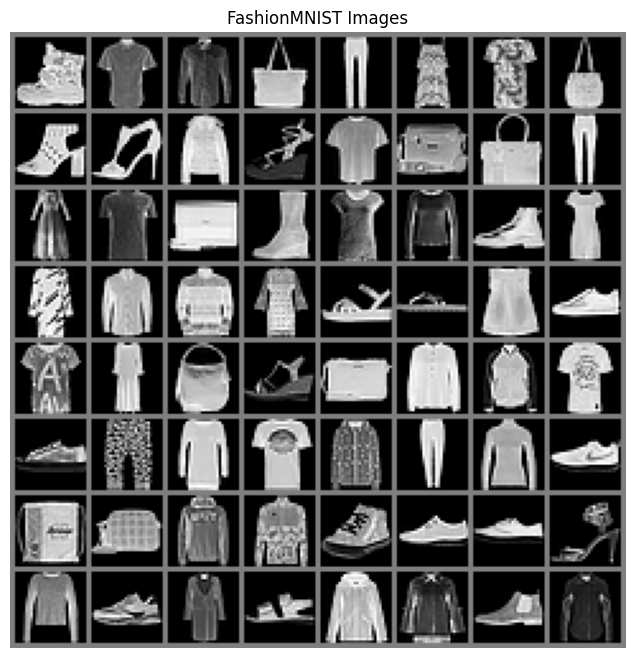

In [3]:
# Usando el train_loader para obtener un batch de imágenes
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Mostrar imágenes
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.title("FashionMNIST Images")
plt.imshow(torchvision.utils.make_grid(images[:64], nrow=8).permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.show()

In [4]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # Suma la pérdida
        pred = output.argmax(dim=1, keepdim=True)  # Obtener el índice del máximo log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')
    return train_loss, accuracy

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Suma la pérdida
            pred = output.argmax(dim=1, keepdim=True)  # Obtener el índice del máximo log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return test_loss, accuracy

In [6]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [7]:
model = SimpleNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [8]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 2.257133 	Accuracy: 23.38%
Test set: Average loss: 2.2048, Accuracy: 1505/5000 (30.10%)
Train Epoch: 2 	Loss: 2.147115 	Accuracy: 32.07%
Test set: Average loss: 2.0845, Accuracy: 1629/5000 (32.58%)
Train Epoch: 3 	Loss: 2.009303 	Accuracy: 33.88%
Test set: Average loss: 1.9322, Accuracy: 2030/5000 (40.60%)
Train Epoch: 4 	Loss: 1.846491 	Accuracy: 44.83%
Test set: Average loss: 1.7666, Accuracy: 2351/5000 (47.02%)
Train Epoch: 5 	Loss: 1.680900 	Accuracy: 48.47%
Test set: Average loss: 1.6058, Accuracy: 2482/5000 (49.64%)
Train Epoch: 6 	Loss: 1.522544 	Accuracy: 52.37%
Test set: Average loss: 1.4548, Accuracy: 2768/5000 (55.36%)
Train Epoch: 7 	Loss: 1.377586 	Accuracy: 59.58%
Test set: Average loss: 1.3221, Accuracy: 3065/5000 (61.30%)
Train Epoch: 8 	Loss: 1.253066 	Accuracy: 64.15%
Test set: Average loss: 1.2104, Accuracy: 3369/5000 (67.38%)
Train Epoch: 9 	Loss: 1.150128 	Accuracy: 67.95%
Test set: Average loss: 1.1204, Accuracy: 3390/5000 (67.80%)
Train Epoc

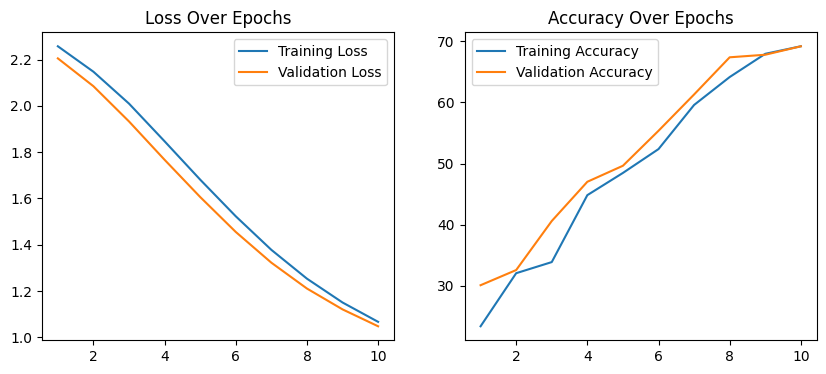

In [9]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 1. ¿Cómo afecta la elección de la función de activación (ReLU vs. Sigmoid vs. Tanh) al entrenamiento de una red neuronal profunda?

Respuesta:

In [10]:
# Código de demostración con el ejemplo proporcionado (entrene diferentes redes cambiando la función de activación a sigmoid y tanh)

In [11]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [12]:
model1 = SimpleNN()
model1.train()
model1.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.003)

In [13]:
train_losses1 = []
train_accuracy1 = []
test_losses1 = []
test_accuracy1 = []

for epoch in range(1, 11):
    train_loss1, train_acc1 = train(model1, device, train_loader, optimizer, epoch)
    test_loss1, test_acc1 = validate(model1, device, test_loader)

    # Almacenamiento de métricas
    train_losses1.append(train_loss1)
    train_accuracy1.append(train_acc1)
    test_losses1.append(test_loss1)
    test_accuracy1.append(test_acc1)

Train Epoch: 1 	Loss: 2.189121 	Accuracy: 26.25%
Test set: Average loss: 2.0612, Accuracy: 1785/5000 (35.70%)
Train Epoch: 2 	Loss: 1.951687 	Accuracy: 46.00%
Test set: Average loss: 1.8533, Accuracy: 2780/5000 (55.60%)
Train Epoch: 3 	Loss: 1.760648 	Accuracy: 61.05%
Test set: Average loss: 1.6829, Accuracy: 3220/5000 (64.40%)
Train Epoch: 4 	Loss: 1.604766 	Accuracy: 65.38%
Test set: Average loss: 1.5451, Accuracy: 3354/5000 (67.08%)
Train Epoch: 5 	Loss: 1.478860 	Accuracy: 68.12%
Test set: Average loss: 1.4335, Accuracy: 3397/5000 (67.94%)
Train Epoch: 6 	Loss: 1.375888 	Accuracy: 68.83%
Test set: Average loss: 1.3415, Accuracy: 3448/5000 (68.96%)
Train Epoch: 7 	Loss: 1.289664 	Accuracy: 70.17%
Test set: Average loss: 1.2637, Accuracy: 3483/5000 (69.66%)
Train Epoch: 8 	Loss: 1.215842 	Accuracy: 70.43%
Test set: Average loss: 1.1966, Accuracy: 3522/5000 (70.44%)
Train Epoch: 9 	Loss: 1.151552 	Accuracy: 71.37%
Test set: Average loss: 1.1383, Accuracy: 3530/5000 (70.60%)
Train Epoc

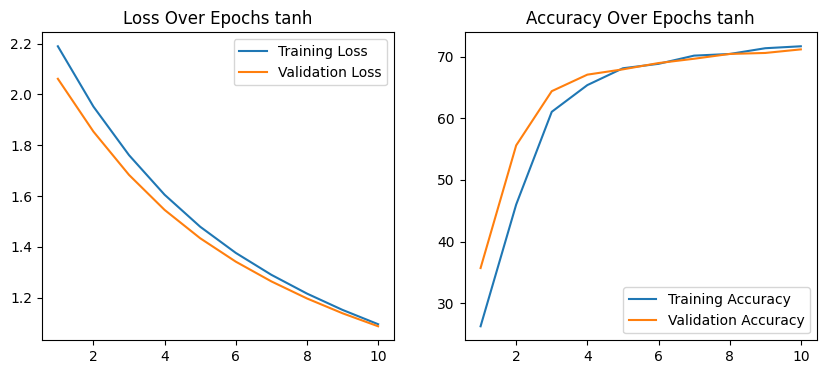

In [14]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses1, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses1, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs tanh')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy1, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy1, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs tanh')

plt.show()

EXPLICACIÓN TANH VS RELU:

**SIGMOID**



In [15]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [16]:
model2 = SimpleNN()
model2.train()
model2.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.003)

In [17]:
train_losses2 = []
train_accuracy2 = []
test_losses2 = []
test_accuracy2 = []

for epoch in range(1, 11):
    train_loss2, train_acc2 = train(model2, device, train_loader, optimizer, epoch)
    test_loss2, test_acc2 = validate(model2, device, test_loader)

    # Almacenamiento de métricas
    train_losses2.append(train_loss2)
    train_accuracy2.append(train_acc2)
    test_losses2.append(test_loss2)
    test_accuracy2.append(test_acc2)

Train Epoch: 1 	Loss: 2.319245 	Accuracy: 10.00%
Test set: Average loss: 2.3102, Accuracy: 500/5000 (10.00%)
Train Epoch: 2 	Loss: 2.305715 	Accuracy: 10.00%
Test set: Average loss: 2.3021, Accuracy: 500/5000 (10.00%)
Train Epoch: 3 	Loss: 2.300033 	Accuracy: 10.10%
Test set: Average loss: 2.2982, Accuracy: 502/5000 (10.04%)
Train Epoch: 4 	Loss: 2.296996 	Accuracy: 10.68%
Test set: Average loss: 2.2958, Accuracy: 573/5000 (11.46%)
Train Epoch: 5 	Loss: 2.294869 	Accuracy: 14.25%
Test set: Average loss: 2.2939, Accuracy: 974/5000 (19.48%)
Train Epoch: 6 	Loss: 2.293039 	Accuracy: 19.78%
Test set: Average loss: 2.2922, Accuracy: 1247/5000 (24.94%)
Train Epoch: 7 	Loss: 2.291438 	Accuracy: 20.95%
Test set: Average loss: 2.2906, Accuracy: 1583/5000 (31.66%)
Train Epoch: 8 	Loss: 2.289744 	Accuracy: 30.20%
Test set: Average loss: 2.2889, Accuracy: 1793/5000 (35.86%)
Train Epoch: 9 	Loss: 2.288080 	Accuracy: 35.97%
Test set: Average loss: 2.2872, Accuracy: 2002/5000 (40.04%)
Train Epoch: 10

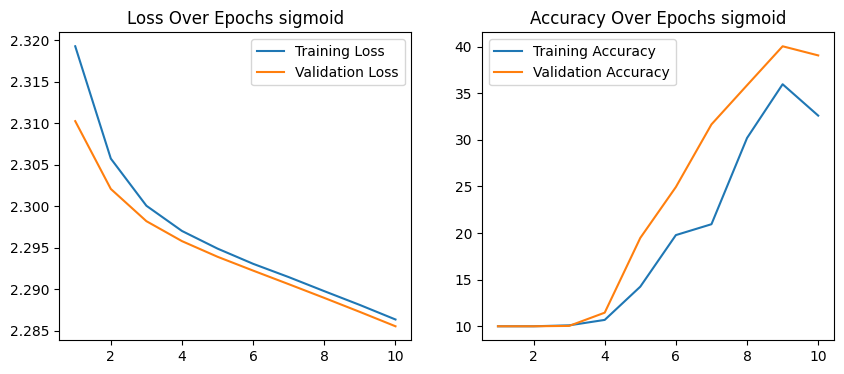

In [18]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses2, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses2, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs sigmoid')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy2, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy2, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs sigmoid')

plt.show()

EXPLICACIÓN SIGMOID VS RELU:

## 2. ¿Qué estrategias puedes emplear para evitar el sobreajuste (overfitting) en redes neuronales profundas?

Respuesta: Para evitar el overfitting en las redes neuronales profundas podemos reducir la el tamaño del modelo usando menos capas o menos epochs. También podemos aplicar la regularización L1 o L2 que tienen en cuenta el valor absoluto y los cuadrados respectivamente. Otra técnica que puede ser útil es reducir el número de epochs ya que hay veces que llegado un punto el rendimiento del modelo no sigue creciendo e incurrimos en el overfitting.

## 3. ¿Cuál es la diferencia entre las funciones de pérdida de entropía cruzada y la MSE (Mean Squared Error), y cuándo es apropiado usar cada una? ¿Qué otras funciones de Loss puede emplear en este problema?

Respuesta: La principal diferencia entre MSE y la entropía cruzada se encuentra en la forma de penalizar los errores. Otra diferencia es que la entropía cruzada tiene en cuenta la incertidumbre del modelo mientras que MSE quiere minimizar la incertidumbre entre las predicciones. Por otra parte, MSE promedia la diferencia de los cuadrados entre las predicciones y el valor real, mientras que la entropía cruzada mide la discrepancia entre la distribución de probabilidad del modelo y y la distribución de las etiquetas. Esta discrepancia no tiene en cuenta los cuadrados.

En el caso de MSE es más conveniente usarlo en problemas de regresión mientras que la entropía cruzada se usa en problemas de clasificación multiclase.

In [19]:
# Código de demostración con el ejemplo proporcionado (entrene con otra función de loss diferente a la dada que sirva para el problema propuesto)

In [20]:
class SimpleNNCategorical(nn.Module):
    def __init__(self):
        super(SimpleNNCategorical, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [21]:
model_categorical = SimpleNNCategorical()
model_categorical.train()
model_categorical.to(device)

# Usar Categorical Cross Entropy Loss y optimizador Adam
criterion_categorical = nn.CrossEntropyLoss()
optimizer_categorical = optim.Adam(model_categorical.parameters(), lr=0.003)

In [22]:
train_losses_categorical = []
train_accuracy_categorical = []
test_losses_categorical = []
test_accuracy_categorical = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model_categorical, device, train_loader, optimizer_categorical, epoch)
    test_loss, test_acc = validate(model_categorical, device, test_loader)

    # Almacenamiento de métricas
    train_losses_categorical.append(train_loss)
    train_accuracy_categorical.append(train_acc)
    test_losses_categorical.append(test_loss)
    test_accuracy_categorical.append(test_acc)

Train Epoch: 1 	Loss: 0.790618 	Accuracy: 71.37%
Test set: Average loss: 0.5718, Accuracy: 3992/5000 (79.84%)
Train Epoch: 2 	Loss: 0.515498 	Accuracy: 80.53%
Test set: Average loss: 0.6281, Accuracy: 3836/5000 (76.72%)
Train Epoch: 3 	Loss: 0.434783 	Accuracy: 83.80%
Test set: Average loss: 0.5320, Accuracy: 4041/5000 (80.82%)
Train Epoch: 4 	Loss: 0.404029 	Accuracy: 84.78%
Test set: Average loss: 0.5515, Accuracy: 4034/5000 (80.68%)
Train Epoch: 5 	Loss: 0.374226 	Accuracy: 86.35%
Test set: Average loss: 0.5368, Accuracy: 4077/5000 (81.54%)
Train Epoch: 6 	Loss: 0.338896 	Accuracy: 87.82%
Test set: Average loss: 0.4572, Accuracy: 4228/5000 (84.56%)
Train Epoch: 7 	Loss: 0.315347 	Accuracy: 88.32%
Test set: Average loss: 0.5160, Accuracy: 4180/5000 (83.60%)
Train Epoch: 8 	Loss: 0.294727 	Accuracy: 88.57%
Test set: Average loss: 0.5056, Accuracy: 4181/5000 (83.62%)
Train Epoch: 9 	Loss: 0.279087 	Accuracy: 89.45%
Test set: Average loss: 0.5107, Accuracy: 4186/5000 (83.72%)
Train Epoc

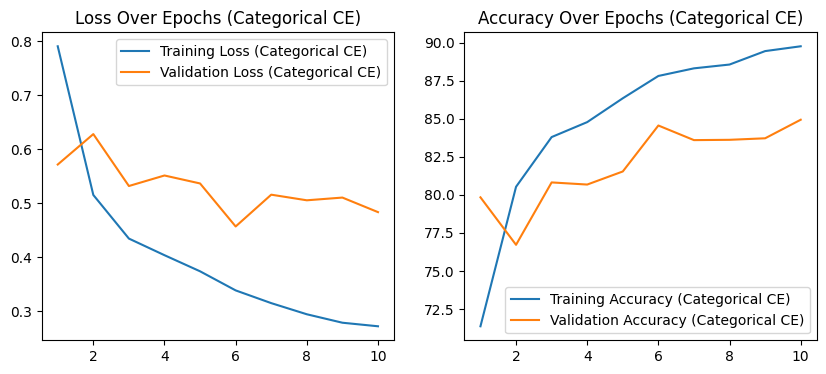

In [23]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_categorical, label='Training Loss (Categorical CE)')
plt.plot(list(range(1, 11)), test_losses_categorical, label='Validation Loss (Categorical CE)')
plt.legend()
plt.title('Loss Over Epochs (Categorical CE)')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_categorical, label='Training Accuracy (Categorical CE)')
plt.plot(list(range(1, 11)), test_accuracy_categorical, label='Validation Accuracy (Categorical CE)')
plt.legend()
plt.title('Accuracy Over Epochs (Categorical CE)')

plt.show()

## 4. ¿Cómo influye el tamaño del batch (batch size) en el proceso de entrenamiento de una red neuronal?

Respuesta:

In [24]:
# Código de demostración con el ejemplo proporcionado (entrene con diferentes tamaños de batch por ejemplo uno muy pequeño (2) y uno grande (512))

In [25]:
train_loader2 = torch.utils.data.DataLoader(stratified_subset, batch_size=2, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(stratified_subset, batch_size=2, shuffle=True)

In [26]:
model = SimpleNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [27]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader2, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader2)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 2.292706 	Accuracy: 13.04%
Test set: Average loss: 2.2701, Accuracy: 605/5000 (12.10%)
Train Epoch: 2 	Loss: 2.218570 	Accuracy: 22.72%
Test set: Average loss: 2.1300, Accuracy: 1289/5000 (25.78%)
Train Epoch: 3 	Loss: 1.956406 	Accuracy: 35.60%
Test set: Average loss: 1.7830, Accuracy: 1983/5000 (39.66%)
Train Epoch: 4 	Loss: 1.644658 	Accuracy: 46.38%
Test set: Average loss: 1.5201, Accuracy: 2689/5000 (53.78%)
Train Epoch: 5 	Loss: 1.422805 	Accuracy: 53.00%
Test set: Average loss: 1.3303, Accuracy: 2824/5000 (56.48%)
Train Epoch: 6 	Loss: 1.266362 	Accuracy: 57.48%
Test set: Average loss: 1.2000, Accuracy: 2942/5000 (58.84%)
Train Epoch: 7 	Loss: 1.152645 	Accuracy: 60.26%
Test set: Average loss: 1.1017, Accuracy: 3243/5000 (64.86%)
Train Epoch: 8 	Loss: 1.060975 	Accuracy: 64.16%
Test set: Average loss: 1.0199, Accuracy: 3137/5000 (62.74%)
Train Epoch: 9 	Loss: 0.983464 	Accuracy: 65.96%
Test set: Average loss: 0.9459, Accuracy: 3260/5000 (65.20%)
Train Epoch

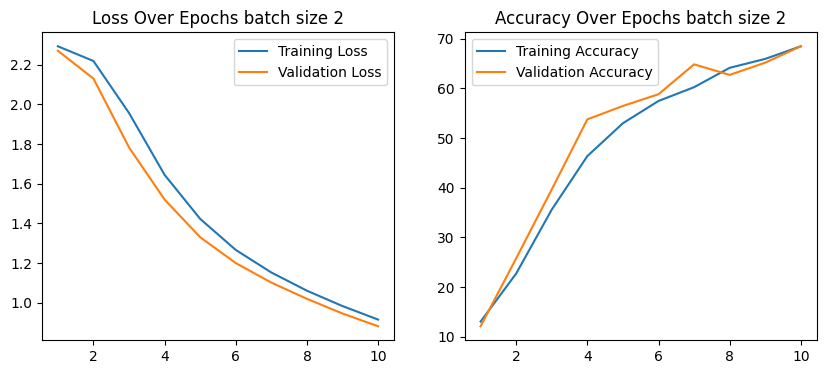

In [28]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs batch size 2')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs batch size 2')

plt.show()

In [29]:
train_loader512 = torch.utils.data.DataLoader(stratified_subset, batch_size=512, shuffle=True)
test_loader512 = torch.utils.data.DataLoader(stratified_subset, batch_size=512, shuffle=True)

In [30]:
model = SimpleNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [31]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader512, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader512)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 2.314640 	Accuracy: 10.00%
Test set: Average loss: 2.3139, Accuracy: 500/5000 (10.00%)
Train Epoch: 2 	Loss: 2.313450 	Accuracy: 10.00%
Test set: Average loss: 2.3128, Accuracy: 500/5000 (10.00%)
Train Epoch: 3 	Loss: 2.312365 	Accuracy: 10.00%
Test set: Average loss: 2.3118, Accuracy: 500/5000 (10.00%)
Train Epoch: 4 	Loss: 2.311411 	Accuracy: 10.00%
Test set: Average loss: 2.3109, Accuracy: 500/5000 (10.00%)
Train Epoch: 5 	Loss: 2.310530 	Accuracy: 10.00%
Test set: Average loss: 2.3100, Accuracy: 500/5000 (10.00%)
Train Epoch: 6 	Loss: 2.309753 	Accuracy: 10.00%
Test set: Average loss: 2.3093, Accuracy: 500/5000 (10.00%)
Train Epoch: 7 	Loss: 2.309030 	Accuracy: 10.00%
Test set: Average loss: 2.3086, Accuracy: 500/5000 (10.00%)
Train Epoch: 8 	Loss: 2.308396 	Accuracy: 10.00%
Test set: Average loss: 2.3080, Accuracy: 500/5000 (10.00%)
Train Epoch: 9 	Loss: 2.307781 	Accuracy: 10.00%
Test set: Average loss: 2.3074, Accuracy: 500/5000 (10.00%)
Train Epoch: 10 	Lo

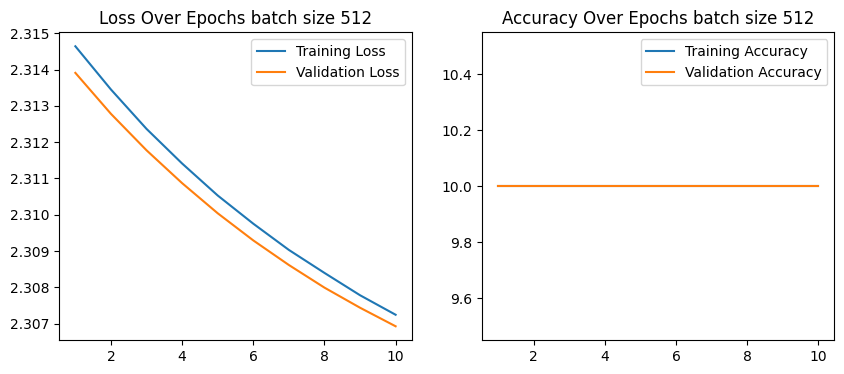

In [32]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs batch size 512')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs batch size 512')

plt.show()

## 5. ¿Qué es la normalización de lotes (batch normalization) y cómo puede mejorar el rendimiento de una red neuronal?

Respuesta: La normalización de lotes consiste en normalizar las activaciones de cada una de las capas intermedias del modelo. El objetivo de aplicar esta técnica es mejorar el entrenamiento y el rendimiento del modelo.

Batch normalization puede mejorar el entrenamiento evitando que las activaciones se saturen. También puede ayudar a preveneir el sobreajuste (overfitting) del modelo. Por último, también puede darse que con batch normalization el modelo converja más rápido.

In [33]:
# Código de demostración con el ejemplo proporcionado (aplique batch normalization tras cada capa de neuronas intermedias de la red)

In [34]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [35]:
model_bn = SimpleNN()
model_bn.train()
model_bn.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_bn.parameters(), lr=0.003)

In [36]:
train_losses_bn = []
train_accuracy_bn = []
test_losses_bn = []
test_accuracy_bn = []

for epoch in range(1, 11):
    train_loss_bn, train_acc_bn = train(model_bn, device, train_loader, optimizer, epoch)
    test_loss_bn, test_acc_bn = validate(model_bn, device, test_loader)

    # Almacenamiento de métricas
    train_losses_bn.append(train_loss_bn)
    train_accuracy_bn.append(train_acc_bn)
    test_losses_bn.append(test_loss_bn)
    test_accuracy_bn.append(test_acc_bn)

Train Epoch: 1 	Loss: 1.776302 	Accuracy: 47.98%
Test set: Average loss: 1.4582, Accuracy: 3361/5000 (67.22%)
Train Epoch: 2 	Loss: 1.343988 	Accuracy: 70.47%
Test set: Average loss: 1.2263, Accuracy: 3591/5000 (71.82%)
Train Epoch: 3 	Loss: 1.146773 	Accuracy: 73.65%
Test set: Average loss: 1.0762, Accuracy: 3690/5000 (73.80%)
Train Epoch: 4 	Loss: 1.010375 	Accuracy: 75.47%
Test set: Average loss: 0.9547, Accuracy: 3784/5000 (75.68%)
Train Epoch: 5 	Loss: 0.912693 	Accuracy: 77.32%
Test set: Average loss: 0.8851, Accuracy: 3846/5000 (76.92%)
Train Epoch: 6 	Loss: 0.841660 	Accuracy: 78.50%
Test set: Average loss: 0.8171, Accuracy: 3909/5000 (78.18%)
Train Epoch: 7 	Loss: 0.781398 	Accuracy: 80.07%
Test set: Average loss: 0.7667, Accuracy: 3958/5000 (79.16%)
Train Epoch: 8 	Loss: 0.733439 	Accuracy: 80.47%
Test set: Average loss: 0.7256, Accuracy: 3979/5000 (79.58%)
Train Epoch: 9 	Loss: 0.693414 	Accuracy: 80.88%
Test set: Average loss: 0.6871, Accuracy: 4007/5000 (80.14%)
Train Epoc

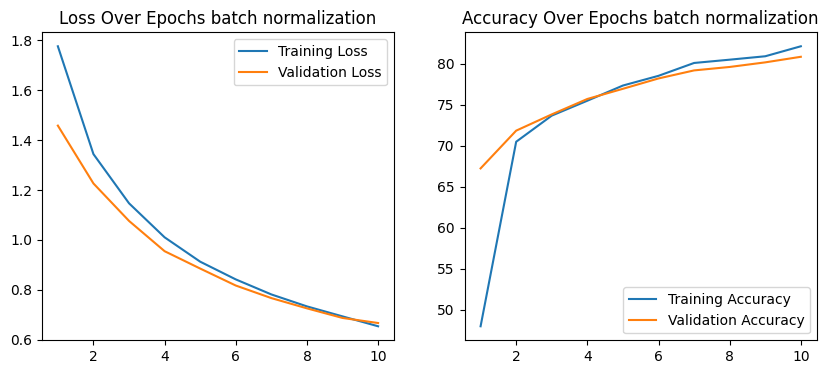

In [37]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_bn, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_bn, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs batch normalization')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_bn, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_bn, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs batch normalization')

plt.show()

## 6. ¿En qué consiste el dropout y cómo ayuda a prevenir el sobreajuste en una red neuronal?

Respuesta: El dropout es una técninca de regularización que puede ayudar a que el modelo no esté sobreajustado. El dropout desactiva una serie de neuronas durante el entrenamiento de tal forma que estas no contribuyen al entrenamiento del modelo. Gracias al dropout se puede obtener un modelo más robusto que no esté sobrejaustado. Además, la desactivación de las neuronas para el entrenamiento hace que las neuronas no sean tan dependientes unas de otras.

In [38]:
# Código de demostración con el ejemplo proporcionado (aplique dropout tras cada capa de neuronas intermedias de la red)

In [39]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout1 = nn.Dropout(0.5)  # Dropout después de la primera capa oculta
        self.dropout2 = nn.Dropout(0.5)  # Dropout después de la segunda capa oculta

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.dropout1(self.fc1(x)))  # Aplicar Dropout después de la primera capa oculta
        x = F.relu(self.dropout2(self.fc2(x)))  # Aplicar Dropout después de la segunda capa oculta
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)



In [40]:
model_dr = SimpleNN()
model_dr.train()
model_dr.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_dr.parameters(), lr=0.003)

In [41]:
train_losses_dr = []
train_accuracy_dr = []
test_losses_dr = []
test_accuracy_dr = []

for epoch in range(1, 11):
    train_loss_dr, train_acc_dr = train(model_dr, device, train_loader, optimizer, epoch)
    test_loss_dr, test_acc_dr = validate(model_dr, device, test_loader)

    # Almacenamiento de métricas
    train_losses_dr.append(train_loss_dr)
    train_accuracy_dr.append(train_acc_dr)
    test_losses_dr.append(test_loss_dr)
    test_accuracy_dr.append(test_acc_dr)

Train Epoch: 1 	Loss: 2.288749 	Accuracy: 14.23%
Test set: Average loss: 2.2481, Accuracy: 1233/5000 (24.66%)
Train Epoch: 2 	Loss: 2.235201 	Accuracy: 19.82%
Test set: Average loss: 2.1822, Accuracy: 1794/5000 (35.88%)
Train Epoch: 3 	Loss: 2.174228 	Accuracy: 25.10%
Test set: Average loss: 2.0991, Accuracy: 2027/5000 (40.54%)
Train Epoch: 4 	Loss: 2.094893 	Accuracy: 29.30%
Test set: Average loss: 1.9944, Accuracy: 2222/5000 (44.44%)
Train Epoch: 5 	Loss: 2.008640 	Accuracy: 32.47%
Test set: Average loss: 1.8690, Accuracy: 2418/5000 (48.36%)
Train Epoch: 6 	Loss: 1.897107 	Accuracy: 35.72%
Test set: Average loss: 1.7293, Accuracy: 2630/5000 (52.60%)
Train Epoch: 7 	Loss: 1.791670 	Accuracy: 38.03%
Test set: Average loss: 1.5943, Accuracy: 2787/5000 (55.74%)
Train Epoch: 8 	Loss: 1.695401 	Accuracy: 40.55%
Test set: Average loss: 1.4767, Accuracy: 2932/5000 (58.64%)
Train Epoch: 9 	Loss: 1.596022 	Accuracy: 42.92%
Test set: Average loss: 1.3767, Accuracy: 3114/5000 (62.28%)
Train Epoc

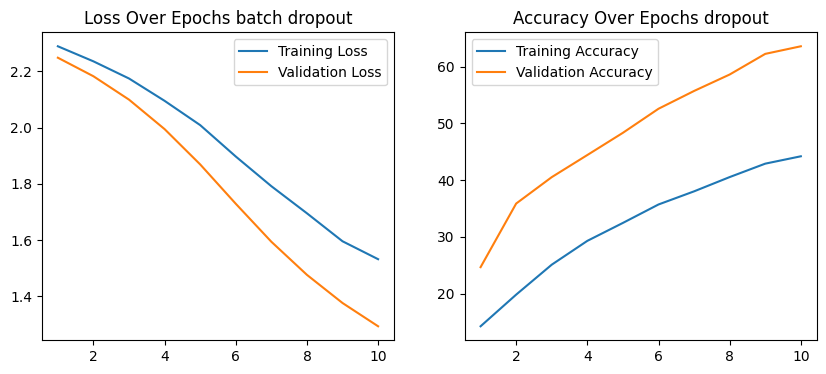

In [42]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_dr, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_dr, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs batch dropout')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_dr, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_dr, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs dropout')

plt.show()

## 7. ¿Cuál es el efecto de cambiar la tasa de aprendizaje (learning rate) durante el entrenamiento de una red neuronal?

Respuesta: El cambiar la tasa de aprendizaje puede suponer distintos cambios en el comportamiento de la red neuronal. Por ejemplo, si subimos el learning rate, el modelo convergerá más rápidamente. Por otra parte, un valor no apropiado de learning rate puede hacer que el entrenmiento no sea estable.

In [43]:
# Código de demostración con el ejemplo proporcionado (modifique el learning rate incrementándolo (0.3) y reduciendólo (0.00003))

In [44]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [45]:
model_lr03 = SimpleNN()
model_lr03.train()
model_lr03.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_lr03.parameters(), lr=0.3)

In [46]:
train_losses_lr03 = []
train_accuracy_lr03 = []
test_losses_lr03 = []
test_accuracy_lr03 = []

for epoch in range(1, 11):
    train_loss_lr03, train_acc_lr03 = train(model_lr03, device, train_loader, optimizer, epoch)
    test_loss_lr03, test_acc_lr03 = validate(model_lr03, device, test_loader)

    # Almacenamiento de métricas
    train_losses_lr03.append(train_loss_lr03)
    train_accuracy_lr03.append(train_acc_lr03)
    test_losses_lr03.append(test_loss_lr03)
    test_accuracy_lr03.append(test_acc_lr03)

Train Epoch: 1 	Loss: 1.165812 	Accuracy: 56.78%
Test set: Average loss: 0.7423, Accuracy: 3610/5000 (72.20%)
Train Epoch: 2 	Loss: 0.667107 	Accuracy: 74.83%
Test set: Average loss: 0.6998, Accuracy: 3641/5000 (72.82%)
Train Epoch: 3 	Loss: 0.571655 	Accuracy: 78.60%
Test set: Average loss: 0.5603, Accuracy: 4006/5000 (80.12%)
Train Epoch: 4 	Loss: 0.522517 	Accuracy: 79.98%
Test set: Average loss: 0.5987, Accuracy: 3935/5000 (78.70%)
Train Epoch: 5 	Loss: 0.477164 	Accuracy: 82.03%
Test set: Average loss: 0.6205, Accuracy: 3812/5000 (76.24%)
Train Epoch: 6 	Loss: 0.449991 	Accuracy: 82.85%
Test set: Average loss: 0.7069, Accuracy: 3769/5000 (75.38%)
Train Epoch: 7 	Loss: 0.421633 	Accuracy: 83.63%
Test set: Average loss: 0.4952, Accuracy: 4125/5000 (82.50%)
Train Epoch: 8 	Loss: 0.416704 	Accuracy: 84.03%
Test set: Average loss: 0.5698, Accuracy: 4010/5000 (80.20%)
Train Epoch: 9 	Loss: 0.374828 	Accuracy: 85.75%
Test set: Average loss: 0.4909, Accuracy: 4168/5000 (83.36%)
Train Epoc

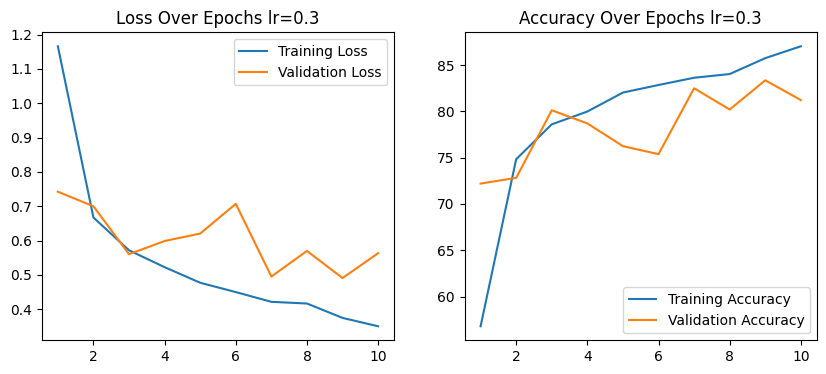

In [47]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_lr03, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_lr03, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs lr=0.3')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_lr03, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_lr03, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs lr=0.3')

plt.show()

Learning rate = 0.00003

In [48]:
model_lr000003 = SimpleNN()
model_lr000003.train()
model_lr000003.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_lr000003.parameters(), lr=0.00003)

In [49]:
train_losses_lr000003 = []
train_accuracy_lr000003 = []
test_losses_lr000003 = []
test_accuracy_lr000003 = []

for epoch in range(1, 11):
    train_loss_lr000003, train_acc_lr000003 = train(model_lr000003, device, train_loader, optimizer, epoch)
    test_loss_lr000003, test_acc_lr000003 = validate(model_lr000003, device, test_loader)

    # Almacenamiento de métricas
    train_losses_lr000003.append(train_loss_lr000003)
    train_accuracy_lr000003.append(train_acc_lr000003)
    test_losses_lr000003.append(test_loss_lr000003)
    test_accuracy_lr000003.append(test_acc_lr000003)

Train Epoch: 1 	Loss: 2.298083 	Accuracy: 9.10%
Test set: Average loss: 2.2978, Accuracy: 459/5000 (9.18%)
Train Epoch: 2 	Loss: 2.297226 	Accuracy: 9.13%
Test set: Average loss: 2.2969, Accuracy: 466/5000 (9.32%)
Train Epoch: 3 	Loss: 2.296366 	Accuracy: 9.28%
Test set: Average loss: 2.2961, Accuracy: 480/5000 (9.60%)
Train Epoch: 4 	Loss: 2.295504 	Accuracy: 9.45%
Test set: Average loss: 2.2952, Accuracy: 492/5000 (9.84%)
Train Epoch: 5 	Loss: 2.294640 	Accuracy: 9.55%
Test set: Average loss: 2.2943, Accuracy: 504/5000 (10.08%)
Train Epoch: 6 	Loss: 2.293774 	Accuracy: 9.82%
Test set: Average loss: 2.2935, Accuracy: 508/5000 (10.16%)
Train Epoch: 7 	Loss: 2.292907 	Accuracy: 10.03%
Test set: Average loss: 2.2926, Accuracy: 519/5000 (10.38%)
Train Epoch: 8 	Loss: 2.292040 	Accuracy: 10.13%
Test set: Average loss: 2.2918, Accuracy: 531/5000 (10.62%)
Train Epoch: 9 	Loss: 2.291171 	Accuracy: 10.42%
Test set: Average loss: 2.2909, Accuracy: 542/5000 (10.84%)
Train Epoch: 10 	Loss: 2.2903

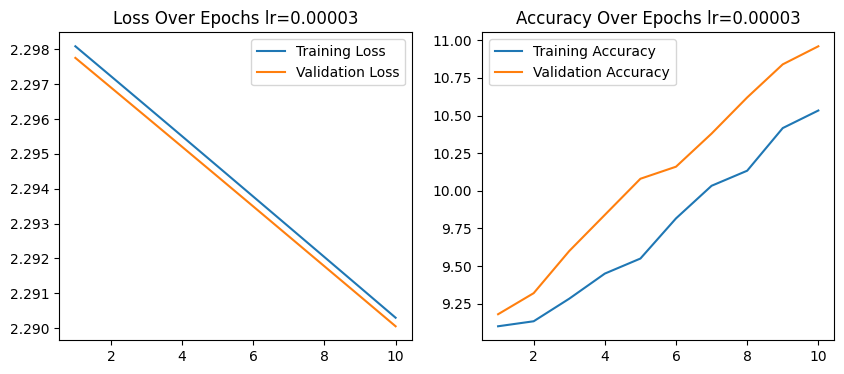

In [50]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_lr000003, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_lr000003, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs lr=0.00003')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_lr000003, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_lr000003, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs lr=0.00003')

plt.show()

## 8. ¿Qué es un optimizador y cómo difieren Adam, SGD, y RMSprop en el contexto de entrenamiento de redes neuronales? ¿Cómo puede afectar la elección del algoritmo de optimización al tiempo de entrenamiento y a la convergencia de una red neuronal?

Respuesta: Los optimizadores son algoritmos o métodos para minimizar una función de pérdida o para maximizar la eficiencia de la producción. En el caso de SGD, utiliza el momentum. Por otra parte, RMSprop combina momentum con AdaGrad y en el caso de Adam se combinan las ventajas de AdaDelta y momentum.

Adam es un algoritmo de optimización que normalmente converge más rápido que RMSprop o SGD, además de ser un algoritmo más estable que no es tan propenso a tener estancamientos como si los tiene SGD. Por estas razones, a día de hoy Adam es considerado uno de los algoritmos de optimización de descenso de gradiente más populares y famosos.

In [51]:
# Código de demostración con el ejemplo proporcionado (pruebe dos optimizadores diferentes al proporcionado inicialmente)

Adam:

In [52]:
model_adam = SimpleNN()
model_adam.train()
model_adam.to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.003)

In [53]:
train_losses_adam = []
train_accuracy_adam = []
test_losses_adam = []
test_accuracy_adam = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model_adam, device, train_loader, optimizer_adam, epoch)
    test_loss, test_acc = validate(model_adam, device, test_loader)

    # Almacenamiento de métricas
    train_losses_adam.append(train_loss)
    train_accuracy_adam.append(train_acc)
    test_losses_adam.append(test_loss)
    test_accuracy_adam.append(test_acc)

Train Epoch: 1 	Loss: 0.816016 	Accuracy: 69.78%
Test set: Average loss: 0.5908, Accuracy: 3892/5000 (77.84%)
Train Epoch: 2 	Loss: 0.542723 	Accuracy: 79.37%
Test set: Average loss: 0.5204, Accuracy: 4073/5000 (81.46%)
Train Epoch: 3 	Loss: 0.445083 	Accuracy: 83.13%
Test set: Average loss: 0.5182, Accuracy: 4086/5000 (81.72%)
Train Epoch: 4 	Loss: 0.431938 	Accuracy: 83.68%
Test set: Average loss: 0.5186, Accuracy: 4090/5000 (81.80%)
Train Epoch: 5 	Loss: 0.380400 	Accuracy: 86.03%
Test set: Average loss: 0.5677, Accuracy: 4023/5000 (80.46%)
Train Epoch: 6 	Loss: 0.363839 	Accuracy: 86.63%
Test set: Average loss: 0.5313, Accuracy: 4071/5000 (81.42%)
Train Epoch: 7 	Loss: 0.319731 	Accuracy: 87.93%
Test set: Average loss: 0.5244, Accuracy: 4146/5000 (82.92%)
Train Epoch: 8 	Loss: 0.307898 	Accuracy: 88.63%
Test set: Average loss: 0.5507, Accuracy: 4080/5000 (81.60%)
Train Epoch: 9 	Loss: 0.285728 	Accuracy: 89.42%
Test set: Average loss: 0.5434, Accuracy: 4104/5000 (82.08%)
Train Epoc

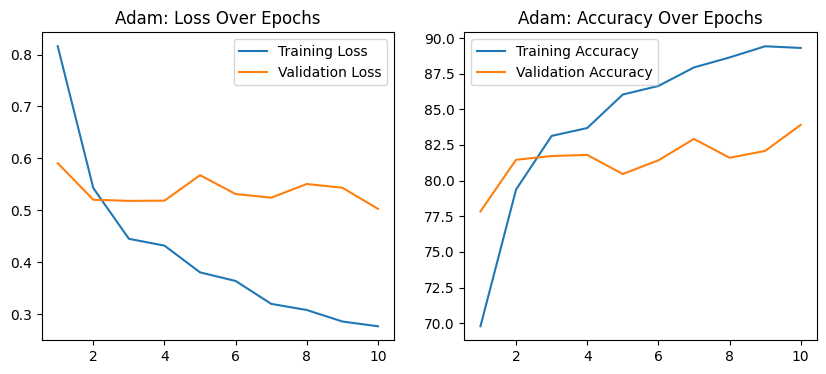

In [54]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_adam, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_adam, label='Validation Loss')
plt.legend()
plt.title('Adam: Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_adam, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_adam, label='Validation Accuracy')
plt.legend()
plt.title('Adam: Accuracy Over Epochs')

plt.show()

RMSprop:

In [55]:
model_rmsprop = SimpleNN()
model_rmsprop.train()
model_rmsprop.to(device)
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.003)

In [56]:
train_losses_rmsprop = []
train_accuracy_rmsprop = []
test_losses_rmsprop = []
test_accuracy_rmsprop = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model_rmsprop, device, train_loader, optimizer_rmsprop, epoch)
    test_loss, test_acc = validate(model_rmsprop, device, test_loader)

    # Almacenamiento de métricas
    train_losses_rmsprop.append(train_loss)
    train_accuracy_rmsprop.append(train_acc)
    test_losses_rmsprop.append(test_loss)
    test_accuracy_rmsprop.append(test_acc)

Train Epoch: 1 	Loss: 1.091779 	Accuracy: 66.85%
Test set: Average loss: 0.6495, Accuracy: 3744/5000 (74.88%)
Train Epoch: 2 	Loss: 0.567569 	Accuracy: 77.80%
Test set: Average loss: 0.5326, Accuracy: 3998/5000 (79.96%)
Train Epoch: 3 	Loss: 0.494995 	Accuracy: 81.10%
Test set: Average loss: 0.5732, Accuracy: 3951/5000 (79.02%)
Train Epoch: 4 	Loss: 0.437567 	Accuracy: 83.57%
Test set: Average loss: 0.5533, Accuracy: 3990/5000 (79.80%)
Train Epoch: 5 	Loss: 0.421803 	Accuracy: 83.92%
Test set: Average loss: 0.5071, Accuracy: 4085/5000 (81.70%)
Train Epoch: 6 	Loss: 0.375838 	Accuracy: 85.63%
Test set: Average loss: 0.5041, Accuracy: 4097/5000 (81.94%)
Train Epoch: 7 	Loss: 0.352880 	Accuracy: 86.55%
Test set: Average loss: 0.5268, Accuracy: 4132/5000 (82.64%)
Train Epoch: 8 	Loss: 0.340439 	Accuracy: 87.23%
Test set: Average loss: 0.5045, Accuracy: 4114/5000 (82.28%)
Train Epoch: 9 	Loss: 0.338316 	Accuracy: 87.37%
Test set: Average loss: 0.5080, Accuracy: 4162/5000 (83.24%)
Train Epoc

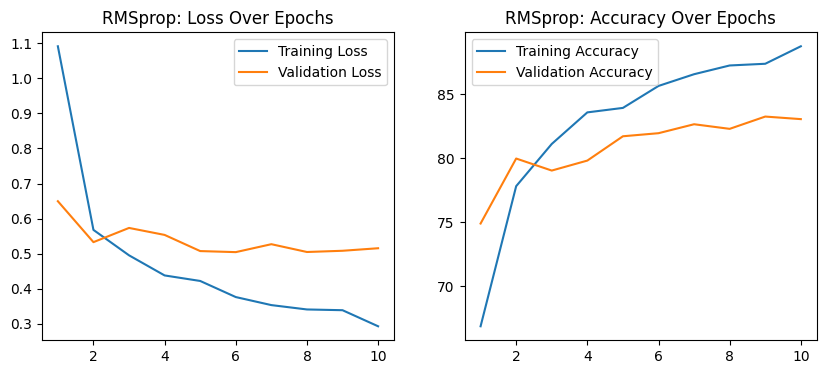

In [57]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_rmsprop, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_rmsprop, label='Validation Loss')
plt.legend()
plt.title('RMSprop: Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_rmsprop, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_rmsprop, label='Validation Accuracy')
plt.legend()
plt.title('RMSprop: Accuracy Over Epochs')

plt.show()

## 9. ¿Por qué es importante realizar una búsqueda de hiperparámetros y cuáles son algunas técnicas comunes para hacerlo?

Respuesta: Como hemos visto en apartados anteriores, los resultados del modelo tras utilizar unos hiprparámetros u otros puede variar significativamente. Por ello, es de vital importancia saber qué hiperparámetros son los que necesitamos para que nuestro modelo funcione de la mejor manera posible. Entre las técnicas de búsqueda de hiperparámetros encontramos la búsqueda manual, aleatoria o el descenso del gradiente.

## 10. ¿Cómo afecta el número de épocas (epochs) al rendimiento de una red neuronal y cómo se determina un número adecuado?

Respuesta: Una época es una pasada hacia delante y una pasada hacia atrás de
todos los ejemplos de entrenamiento. Elegir un número demasiado bajo de épocas puede hacer que tengamos underfitting, de la misma manera que si el número de épocas es excesivamente alto, el modelo estará sobreajustado y habrá overfitting. Además, el número de épocas también tiene influencia en la curva de aprendizaje. Lo mejor para determinar un número adecuado de épocas es probar distintos valores y decidir según observemos en la gráfica. Si por ejemplo se ve que 2 líneas son paralelas no hará falta poner más épocas.

In [58]:
# Código de demostración con el ejemplo proporcionado (incremente el número de epochs (>50))

In [59]:
model = SimpleNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [60]:
train_losses_ep50 = []
train_accuracy_ep50 = []
test_losses_ep50 = []
test_accuracy_ep50 = []

# Incrementar el número de épocas a más de 50
for epoch in range(1, 51):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses_ep50.append(train_loss)
    train_accuracy_ep50.append(train_acc)
    test_losses_ep50.append(test_loss)
    test_accuracy_ep50.append(test_acc)

Train Epoch: 1 	Loss: 2.265966 	Accuracy: 21.02%
Test set: Average loss: 2.2234, Accuracy: 1576/5000 (31.52%)
Train Epoch: 2 	Loss: 2.174874 	Accuracy: 36.93%
Test set: Average loss: 2.1230, Accuracy: 2035/5000 (40.70%)
Train Epoch: 3 	Loss: 2.054823 	Accuracy: 44.13%
Test set: Average loss: 1.9843, Accuracy: 2364/5000 (47.28%)
Train Epoch: 4 	Loss: 1.897429 	Accuracy: 48.78%
Test set: Average loss: 1.8142, Accuracy: 2553/5000 (51.06%)
Train Epoch: 5 	Loss: 1.719536 	Accuracy: 52.57%
Test set: Average loss: 1.6365, Accuracy: 2705/5000 (54.10%)
Train Epoch: 6 	Loss: 1.544759 	Accuracy: 56.47%
Test set: Average loss: 1.4715, Accuracy: 2932/5000 (58.64%)
Train Epoch: 7 	Loss: 1.387908 	Accuracy: 60.77%
Test set: Average loss: 1.3290, Accuracy: 3106/5000 (62.12%)
Train Epoch: 8 	Loss: 1.255611 	Accuracy: 64.32%
Test set: Average loss: 1.2129, Accuracy: 3298/5000 (65.96%)
Train Epoch: 9 	Loss: 1.149926 	Accuracy: 67.62%
Test set: Average loss: 1.1211, Accuracy: 3334/5000 (66.68%)
Train Epoc

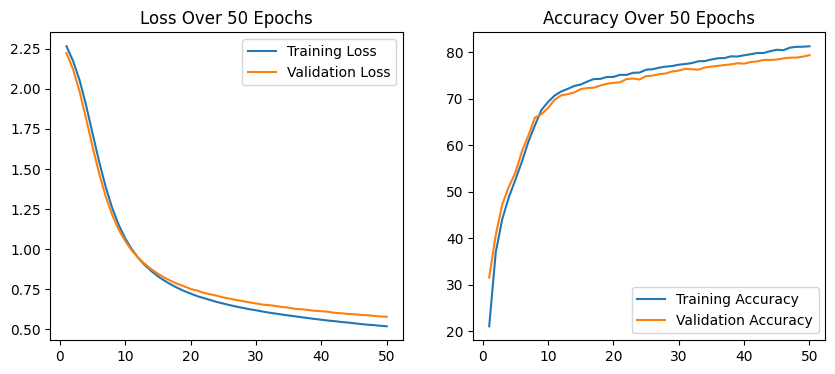

In [61]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 51)), train_losses_ep50, label='Training Loss')
plt.plot(list(range(1, 51)), test_losses_ep50, label='Validation Loss')
plt.legend()
plt.title('Loss Over 50 Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 51)), train_accuracy_ep50, label='Training Accuracy')
plt.plot(list(range(1, 51)), test_accuracy_ep50, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over 50 Epochs')

plt.show()

## 11. ¿Qué impacto tiene la inicialización de pesos en el entrenamiento y rendimiento de una red neuronal?

Respuesta: Cada neurona tiene unos pesos propios que se utilizan para ponderar las distintas características. Durante el entrenamiento, hay que seleccionar los pesos de cada neurona para que la salida sea fiel a la realidad. Por ello, la elección de unos pesos u otros tiene un gran impacto en el comportamiento de la red.

In [62]:
# Código de demostración con el ejemplo proporcionado (inicialice los pesos con por ejemplo Kaiming o He y entrene)

In [63]:
import torch.nn.init as init

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        # Inicialización de los pesos con Kaiming
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [64]:
model = SimpleNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [65]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):  # Modificado a 50 épocas
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 1.796483 	Accuracy: 42.55%
Test set: Average loss: 1.3269, Accuracy: 2988/5000 (59.76%)
Train Epoch: 2 	Loss: 1.126116 	Accuracy: 64.88%
Test set: Average loss: 1.0095, Accuracy: 3366/5000 (67.32%)
Train Epoch: 3 	Loss: 0.904171 	Accuracy: 70.18%
Test set: Average loss: 0.8681, Accuracy: 3520/5000 (70.40%)
Train Epoch: 4 	Loss: 0.794822 	Accuracy: 73.12%
Test set: Average loss: 0.7945, Accuracy: 3633/5000 (72.66%)
Train Epoch: 5 	Loss: 0.730445 	Accuracy: 74.83%
Test set: Average loss: 0.7480, Accuracy: 3676/5000 (73.52%)
Train Epoch: 6 	Loss: 0.687375 	Accuracy: 76.30%
Test set: Average loss: 0.7123, Accuracy: 3725/5000 (74.50%)
Train Epoch: 7 	Loss: 0.654474 	Accuracy: 77.13%
Test set: Average loss: 0.6857, Accuracy: 3775/5000 (75.50%)
Train Epoch: 8 	Loss: 0.628004 	Accuracy: 78.00%
Test set: Average loss: 0.6648, Accuracy: 3808/5000 (76.16%)
Train Epoch: 9 	Loss: 0.606391 	Accuracy: 78.50%
Test set: Average loss: 0.6545, Accuracy: 3804/5000 (76.08%)
Train Epoc

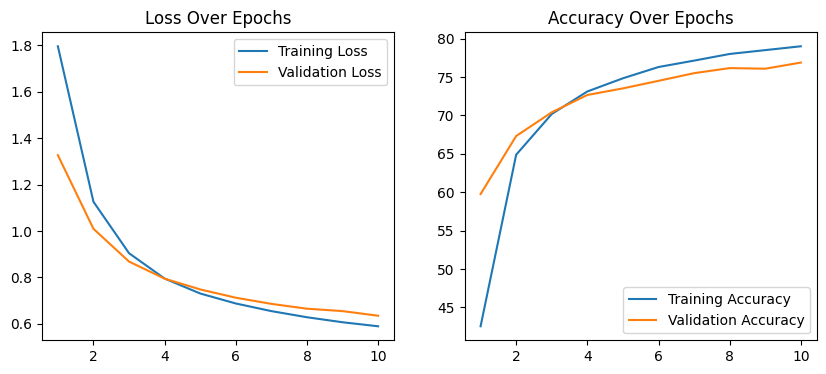

In [66]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 12. ¿Cómo seleccionar la arquitectura de una red neuronal (número y tipo de capas) para un problema específico?

Respuesta: Algunas de las consideraciones que hay que tener en cuenta a la hora de seleccionar una arquitectura para una red neuronal son conocer la cantidad y tipos de datos con los que se va a trabajar en el problema específico. Por ejemplo, si vamos a abordar un problema con imágenes sería más adecuado decantarse por una red convolucional (CNN), mientras que si vamos a trabajar con texto sería más adecuado usar una red neuronal recurrente (RNN).

# CNN

In [67]:
# Definición de la red convolucional
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Capa convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Segunda capa convolucional
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Capa totalmente conectada
        self.fc2 = nn.Linear(120, 10)  # Capa de salida

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [68]:
# Instanciar la red,
model = SimpleCNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [69]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 2.281401 	Accuracy: 17.73%
Test set: Average loss: 2.2588, Accuracy: 1336/5000 (26.72%)
Train Epoch: 2 	Loss: 2.232555 	Accuracy: 35.07%
Test set: Average loss: 2.2008, Accuracy: 2122/5000 (42.44%)
Train Epoch: 3 	Loss: 2.152502 	Accuracy: 45.13%
Test set: Average loss: 2.0909, Accuracy: 2405/5000 (48.10%)
Train Epoch: 4 	Loss: 1.990003 	Accuracy: 47.95%
Test set: Average loss: 1.8647, Accuracy: 2494/5000 (49.88%)
Train Epoch: 5 	Loss: 1.691470 	Accuracy: 54.85%
Test set: Average loss: 1.5108, Accuracy: 2908/5000 (58.16%)
Train Epoch: 6 	Loss: 1.342503 	Accuracy: 62.28%
Test set: Average loss: 1.2089, Accuracy: 3016/5000 (60.32%)
Train Epoch: 7 	Loss: 1.090337 	Accuracy: 66.58%
Test set: Average loss: 1.0201, Accuracy: 3285/5000 (65.70%)
Train Epoch: 8 	Loss: 0.932935 	Accuracy: 69.72%
Test set: Average loss: 0.9062, Accuracy: 3378/5000 (67.56%)
Train Epoch: 9 	Loss: 0.838014 	Accuracy: 71.65%
Test set: Average loss: 0.8468, Accuracy: 3465/5000 (69.30%)
Train Epoc

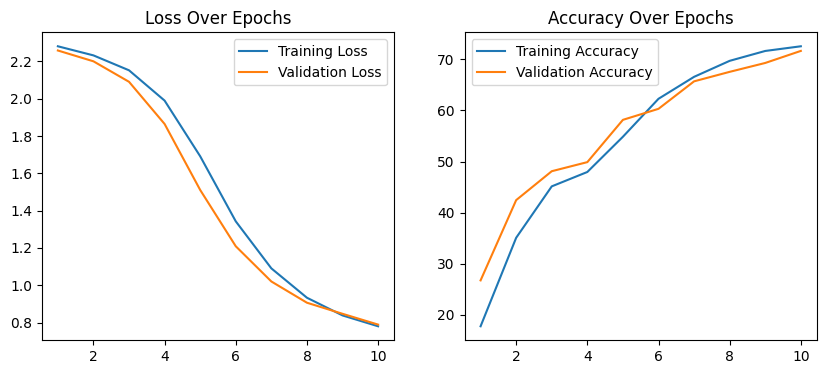

In [70]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 13. ¿Qué impacto tiene el tamaño del kernel en las dimensiones de salida de una capa convolucional y cómo puede influir en el aprendizaje del modelo?

Respuesta: Un tamaño más pequeño hará que el modelo capte detalles locales y ayudan a evitar el overfitting. Por otra parte, un tamaño grande perderá detalles finos pero captará mejor patrones globales.

In [71]:
# Código de demostración con el ejemplo proporcionado (entrene la red con diferentes tamaños de kernel por ejemplo 9 y 3)

In [72]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Capa convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Segunda capa convolucional
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Capa totalmente conectada
        self.fc2 = nn.Linear(120, 10)  # Capa de salida

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [73]:
# Instanciar la red,
model_k3 = SimpleCNN()
model_k3.train()
model_k3.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_k3.parameters(), lr=0.003)

In [74]:
train_losses_k3 = []
train_accuracy_k3 = []
test_losses_k3 = []
test_accuracy_k3 = []


for epoch in range(1, 11):
    train_loss, train_acc = train(model_k3, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model_k3, device, test_loader)

    # Almacenamiento de métricas
    train_losses_k3.append(train_loss)
    train_accuracy_k3.append(train_acc)
    test_losses_k3.append(test_loss)
    test_accuracy_k3.append(test_acc)

Train Epoch: 1 	Loss: 2.288176 	Accuracy: 19.72%
Test set: Average loss: 2.2721, Accuracy: 1114/5000 (22.28%)
Train Epoch: 2 	Loss: 2.254345 	Accuracy: 27.57%
Test set: Average loss: 2.2350, Accuracy: 1552/5000 (31.04%)
Train Epoch: 3 	Loss: 2.209539 	Accuracy: 34.80%
Test set: Average loss: 2.1799, Accuracy: 1873/5000 (37.46%)
Train Epoch: 4 	Loss: 2.137081 	Accuracy: 38.33%
Test set: Average loss: 2.0862, Accuracy: 2069/5000 (41.38%)
Train Epoch: 5 	Loss: 2.011468 	Accuracy: 41.52%
Test set: Average loss: 1.9222, Accuracy: 2149/5000 (42.98%)
Train Epoch: 6 	Loss: 1.805670 	Accuracy: 44.55%
Test set: Average loss: 1.6819, Accuracy: 2335/5000 (46.70%)
Train Epoch: 7 	Loss: 1.549126 	Accuracy: 51.52%
Test set: Average loss: 1.4279, Accuracy: 2887/5000 (57.74%)
Train Epoch: 8 	Loss: 1.313763 	Accuracy: 61.18%
Test set: Average loss: 1.2237, Accuracy: 3187/5000 (63.74%)
Train Epoch: 9 	Loss: 1.134570 	Accuracy: 65.33%
Test set: Average loss: 1.0742, Accuracy: 3346/5000 (66.92%)
Train Epoc

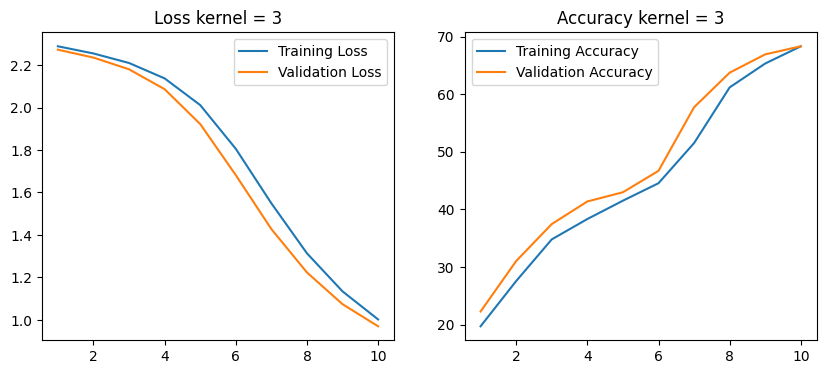

In [75]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_k3, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_k3, label='Validation Loss')
plt.legend()
plt.title('Loss kernel = 3')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_k3, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_k3, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy kernel = 3')

plt.show()

In [76]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=9, stride=1, padding=4)  # Capa convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=9, stride=1, padding=4)  # Segunda capa convolucional
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Capa totalmente conectada
        self.fc2 = nn.Linear(120, 10)  # Capa de salida

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [77]:
# Instanciar la red,
model_k9 = SimpleCNN()
model_k9.train()
model_k9.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_k9.parameters(), lr=0.003)

In [78]:
train_losses_k9 = []
train_accuracy_k9 = []
test_losses_k9 = []
test_accuracy_k9 = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model_k9, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model_k9, device, test_loader)

    # Almacenamiento de métricas
    train_losses_k9.append(train_losses_k9 )
    train_accuracy_k9.append(train_accuracy_k9)
    test_losses_k9.append(test_losses_k9)
    test_accuracy_k9.append(test_accuracy_k9)

Train Epoch: 1 	Loss: 2.268547 	Accuracy: 17.63%
Test set: Average loss: 2.2296, Accuracy: 1802/5000 (36.04%)
Train Epoch: 2 	Loss: 2.164178 	Accuracy: 44.23%
Test set: Average loss: 2.0725, Accuracy: 2311/5000 (46.22%)
Train Epoch: 3 	Loss: 1.907415 	Accuracy: 46.58%
Test set: Average loss: 1.7014, Accuracy: 2301/5000 (46.02%)
Train Epoch: 4 	Loss: 1.466480 	Accuracy: 55.03%
Test set: Average loss: 1.2608, Accuracy: 2936/5000 (58.72%)
Train Epoch: 5 	Loss: 1.120515 	Accuracy: 63.38%
Test set: Average loss: 1.0200, Accuracy: 3167/5000 (63.34%)
Train Epoch: 6 	Loss: 0.940529 	Accuracy: 67.00%
Test set: Average loss: 0.9217, Accuracy: 3393/5000 (67.86%)
Train Epoch: 7 	Loss: 0.852060 	Accuracy: 69.75%
Test set: Average loss: 0.8471, Accuracy: 3503/5000 (70.06%)
Train Epoch: 8 	Loss: 0.801402 	Accuracy: 71.32%
Test set: Average loss: 0.8316, Accuracy: 3415/5000 (68.30%)
Train Epoch: 9 	Loss: 0.770917 	Accuracy: 71.53%
Test set: Average loss: 0.8039, Accuracy: 3565/5000 (71.30%)
Train Epoc

In [79]:
'''# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_k9, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_k9, label='Validation Loss')
plt.legend()
plt.title('Loss kernel = 9')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_k9, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_k9, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy kernel = 9')

plt.show()'''

"# Visualización de las métricas\nplt.figure(figsize=(10, 4))\nplt.subplot(1, 2, 1)\nplt.plot(list(range(1, 11)), train_losses_k9, label='Training Loss')\nplt.plot(list(range(1, 11)), test_losses_k9, label='Validation Loss')\nplt.legend()\nplt.title('Loss kernel = 9')\n\nplt.subplot(1, 2, 2)\nplt.plot(list(range(1, 11)), train_accuracy_k9, label='Training Accuracy')\nplt.plot(list(range(1, 11)), test_accuracy_k9, label='Validation Accuracy')\nplt.legend()\nplt.title('Accuracy kernel = 9')\n\nplt.show()"

## 14. ¿Qué impacto tiene el stride en las dimensiones de salida de una capa convolucional y cómo puede influir en el aprendizaje del modelo?

Respuesta: Un stride pequeño mantiene una resolución alta de salida, es bueno para tareas de alta prescisión. Sin embargo, un stride alto reduce la resolución de salida, así como la dimensionalidad.

In [80]:
# Código de demostración con el ejemplo proporcionado (entrene la red con un stride mayor del proporcionado (2 ó 3))

In [81]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding='valid')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding='valid')
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(576, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output


In [82]:
# Instanciar la red
model_stride = Net()
model_stride.train()
model_stride.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_stride.parameters(), lr=0.003)


In [83]:
train_losses_stride = []
train_accuracy_stride  = []
test_losses_stride  = []
test_accuracy_stride  = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model_stride , device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model_stride , device, test_loader)

    # Almacenamiento de métricas
    train_losses_stride.append(train_loss)
    train_accuracy_stride.append(train_acc)
    test_losses_stride.append(test_loss)
    test_accuracy_stride.append(test_acc)

Train Epoch: 1 	Loss: -0.100062 	Accuracy: 9.53%
Test set: Average loss: -0.1001, Accuracy: 497/5000 (9.94%)
Train Epoch: 2 	Loss: -0.100130 	Accuracy: 9.88%
Test set: Average loss: -0.1002, Accuracy: 498/5000 (9.96%)
Train Epoch: 3 	Loss: -0.100206 	Accuracy: 9.68%
Test set: Average loss: -0.1002, Accuracy: 498/5000 (9.96%)
Train Epoch: 4 	Loss: -0.100234 	Accuracy: 9.50%
Test set: Average loss: -0.1003, Accuracy: 499/5000 (9.98%)
Train Epoch: 5 	Loss: -0.100246 	Accuracy: 9.63%
Test set: Average loss: -0.1003, Accuracy: 501/5000 (10.02%)
Train Epoch: 6 	Loss: -0.100292 	Accuracy: 9.87%
Test set: Average loss: -0.1004, Accuracy: 501/5000 (10.02%)
Train Epoch: 7 	Loss: -0.100359 	Accuracy: 9.78%
Test set: Average loss: -0.1004, Accuracy: 501/5000 (10.02%)
Train Epoch: 8 	Loss: -0.100399 	Accuracy: 10.17%
Test set: Average loss: -0.1005, Accuracy: 501/5000 (10.02%)
Train Epoch: 9 	Loss: -0.100455 	Accuracy: 10.20%
Test set: Average loss: -0.1005, Accuracy: 501/5000 (10.02%)
Train Epoch:

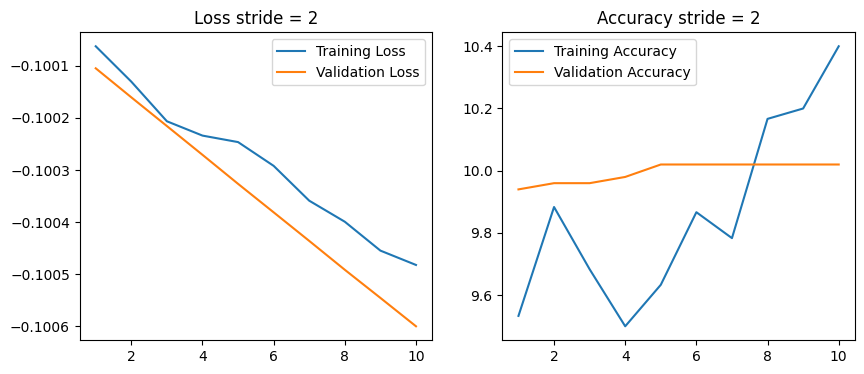

In [84]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_stride, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_stride, label='Validation Loss')
plt.legend()
plt.title('Loss stride = 2')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_stride, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_stride, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy stride = 2')

plt.show()

## 15. ¿Cuál es el efecto de aumentar o disminuir el número de filtros (canales de salida) en las capas convolucionales sobre la capacidad de la red?

Respuesta: Aumentar los filtros mejora la capacidad de aprendizaje pero puede llevar a overfitting y mayor demanda computacional, mientras que disminuirlos reduce la capacidad de representación pero también el riesgo de overfitting y la carga computacional.

In [85]:
# Código de demostración con el ejemplo proporcionado (entrene la red con modificando el número de filtros en las capas)

In [86]:
# Definición de la red convolucional
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2)  # Capa convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2)  # Segunda capa convolucional
        self.fc1 = nn.Linear(8 * 7 * 7, 120)  # Capa totalmente conectada
        self.fc2 = nn.Linear(120, 10)  # Capa de salida

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instanciar la red,
model = SimpleCNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 2.304173 	Accuracy: 10.00%
Test set: Average loss: 2.2994, Accuracy: 500/5000 (10.00%)
Train Epoch: 2 	Loss: 2.295000 	Accuracy: 10.00%
Test set: Average loss: 2.2902, Accuracy: 496/5000 (9.92%)
Train Epoch: 3 	Loss: 2.285253 	Accuracy: 9.92%
Test set: Average loss: 2.2796, Accuracy: 508/5000 (10.16%)
Train Epoch: 4 	Loss: 2.273193 	Accuracy: 10.87%
Test set: Average loss: 2.2661, Accuracy: 633/5000 (12.66%)
Train Epoch: 5 	Loss: 2.256859 	Accuracy: 20.48%
Test set: Average loss: 2.2465, Accuracy: 1492/5000 (29.84%)
Train Epoch: 6 	Loss: 2.231744 	Accuracy: 36.02%
Test set: Average loss: 2.2148, Accuracy: 2047/5000 (40.94%)
Train Epoch: 7 	Loss: 2.189265 	Accuracy: 42.98%
Test set: Average loss: 2.1591, Accuracy: 2254/5000 (45.08%)
Train Epoch: 8 	Loss: 2.109970 	Accuracy: 46.58%
Test set: Average loss: 2.0496, Accuracy: 2398/5000 (47.96%)
Train Epoch: 9 	Loss: 1.950438 	Accuracy: 49.63%
Test set: Average loss: 1.8315, Accuracy: 2379/5000 (47.58%)
Train Epoch: 10 

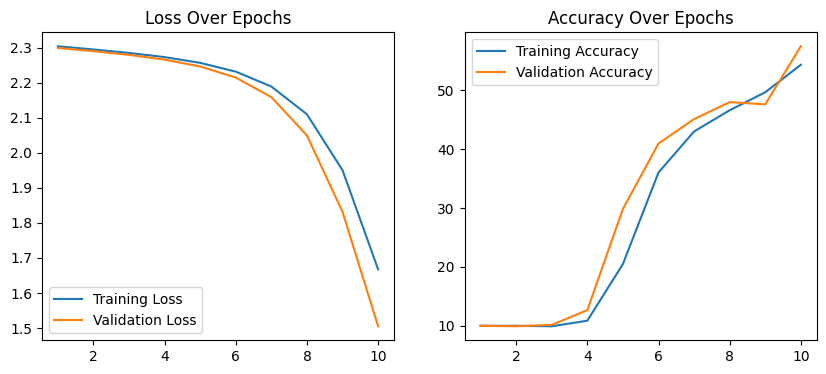

In [87]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 16. Explique la importancia de las capas de pooling en una CNN y cómo la elección entre max pooling y average pooling afecta al modelo. ¿Existen otros métodos de pooling? Comente alguno de ellos.

Respuesta: Las capas de pooling son esenciales para reducir la dimensionalidad y mejorar la robustez de la red, con la elección del método de pooling influenciada por la tarea específica y las necesidades del modelo.

In [88]:
# Código de demostración con el ejemplo proporcionado (modifique la capa de pooling con average pooling)

In [89]:
# Definición de la red convolucional
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Capa convolucional
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Capa de pooling (average pooling)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Segunda capa convolucional
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Capa totalmente conectada
        self.fc2 = nn.Linear(120, 10)  # Capa de salida

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instanciar la red
model = SimpleCNN()
model.train()
model.to(device)

# Definir criterio y optimizador
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

# Listas para almacenar las métricas
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

# Entrenamiento por 10 épocas
for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenar las métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)


Train Epoch: 1 	Loss: 2.292382 	Accuracy: 16.03%
Test set: Average loss: 2.2827, Accuracy: 878/5000 (17.56%)
Train Epoch: 2 	Loss: 2.270687 	Accuracy: 21.58%
Test set: Average loss: 2.2559, Accuracy: 1268/5000 (25.36%)
Train Epoch: 3 	Loss: 2.231697 	Accuracy: 24.40%
Test set: Average loss: 2.1999, Accuracy: 1070/5000 (21.40%)
Train Epoch: 4 	Loss: 2.142334 	Accuracy: 22.97%
Test set: Average loss: 2.0632, Accuracy: 1294/5000 (25.88%)
Train Epoch: 5 	Loss: 1.919689 	Accuracy: 38.85%
Test set: Average loss: 1.7366, Accuracy: 2712/5000 (54.24%)
Train Epoch: 6 	Loss: 1.522515 	Accuracy: 56.10%
Test set: Average loss: 1.3310, Accuracy: 3065/5000 (61.30%)
Train Epoch: 7 	Loss: 1.181197 	Accuracy: 62.82%
Test set: Average loss: 1.0756, Accuracy: 3208/5000 (64.16%)
Train Epoch: 8 	Loss: 0.992283 	Accuracy: 65.45%
Test set: Average loss: 0.9472, Accuracy: 3311/5000 (66.22%)
Train Epoch: 9 	Loss: 0.894771 	Accuracy: 67.00%
Test set: Average loss: 0.8867, Accuracy: 3452/5000 (69.04%)
Train Epoch

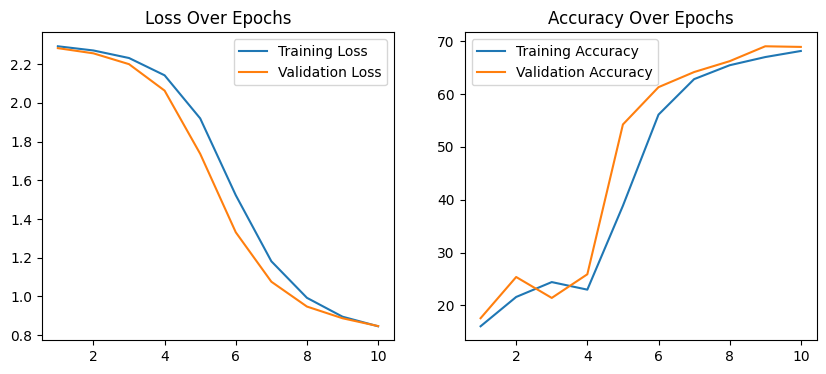

In [90]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 17. Discuta cómo la profundidad de una CNN afecta su capacidad para aprender patrones complejos en los datos.

Respuesta: Una mayor profundidad en una CNN permite aprender patrones más complejos y jerárquicos, pero requiere regularización y más recursos computacionales. La elección de la profundidad debe equilibrar la complejidad del problema y los recursos disponibles.

In [91]:
# Código de demostración con el ejemplo proporcionado (añada una capa convolucional + activación + pooling al modelo)

In [92]:
# Define the architecture of the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='valid')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='valid')
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.75)
        self.fc1 = nn.Linear(128 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 64)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output





# Instanciar la red
model = Net()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

# Listas para almacenar las métricas
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

# Entrenamiento por 10 épocas
for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenar las métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: -0.015824 	Accuracy: 0.02%
Test set: Average loss: -0.0158, Accuracy: 0/5000 (0.00%)
Train Epoch: 2 	Loss: -0.015831 	Accuracy: 0.08%
Test set: Average loss: -0.0158, Accuracy: 0/5000 (0.00%)
Train Epoch: 3 	Loss: -0.015853 	Accuracy: 0.07%
Test set: Average loss: -0.0159, Accuracy: 0/5000 (0.00%)
Train Epoch: 4 	Loss: -0.015877 	Accuracy: 0.05%
Test set: Average loss: -0.0159, Accuracy: 0/5000 (0.00%)
Train Epoch: 5 	Loss: -0.015896 	Accuracy: 0.05%
Test set: Average loss: -0.0159, Accuracy: 0/5000 (0.00%)
Train Epoch: 6 	Loss: -0.015907 	Accuracy: 0.05%
Test set: Average loss: -0.0159, Accuracy: 0/5000 (0.00%)
Train Epoch: 7 	Loss: -0.015940 	Accuracy: 0.05%
Test set: Average loss: -0.0159, Accuracy: 0/5000 (0.00%)
Train Epoch: 8 	Loss: -0.015950 	Accuracy: 0.07%
Test set: Average loss: -0.0160, Accuracy: 0/5000 (0.00%)
Train Epoch: 9 	Loss: -0.015970 	Accuracy: 0.10%
Test set: Average loss: -0.0160, Accuracy: 0/5000 (0.00%)
Train Epoch: 10 	Loss: -0.015989 	Acc

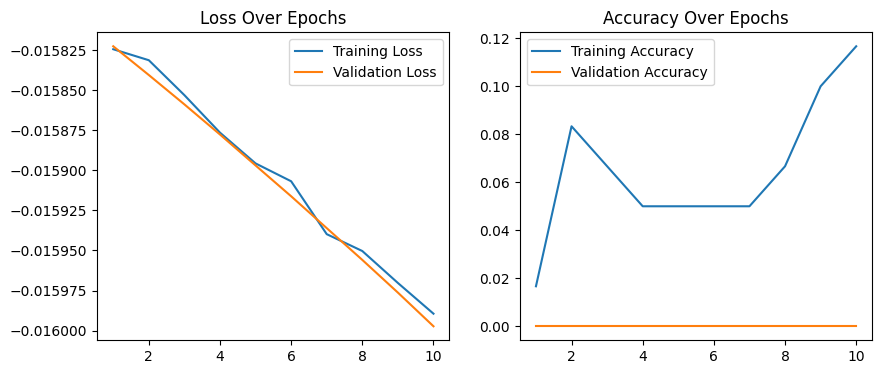

In [93]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 18. ¿Cómo influyen las técnicas de regularización, como dropout y la normalización por lotes (batch normalization), en el entrenamiento y la generalización de una CNN?

Respuesta: Ambas técnicas mejoran el rendimiento de las CNNs de maneras complementarias: Dropout previene el overfitting al apagar neuronas aleatoriamente, mientras que Batch Normalization estabiliza y acelera el entrenamiento normalizando las activaciones dentro de los mini-batches. Su uso combinado puede llevar a una mejora significativa tanto en la velocidad de entrenamiento como en la capacidad de generalización del modelo.

In [94]:
# Código de demostración con el ejemplo proporcionado (incluya batch normalization y dropout en la red cnn)

In [95]:
# Definición de la red convolucional
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Capa convolucional
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization después de la primera capa convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Segunda capa convolucional
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization después de la segunda capa convolucional
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Capa totalmente conectada
        self.fc2 = nn.Linear(120, 10)  # Capa de salida
        self.dropout = nn.Dropout(0.5)  # Dropout con una probabilidad de 0.5

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Aplicar Batch Normalization después de la primera capa convolucional
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Aplicar Batch Normalization después de la segunda capa convolucional
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Aplicar Dropout después de la primera capa totalmente conectada
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [96]:
model = CNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [97]:
# Listas para almacenar las métricas
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

# Entrenamiento por 10 épocas
for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenar las métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 1.838803 	Accuracy: 41.12%
Test set: Average loss: 1.4003, Accuracy: 3496/5000 (69.92%)
Train Epoch: 2 	Loss: 1.271567 	Accuracy: 62.40%
Test set: Average loss: 1.0252, Accuracy: 3659/5000 (73.18%)
Train Epoch: 3 	Loss: 1.027173 	Accuracy: 67.38%
Test set: Average loss: 0.8545, Accuracy: 3713/5000 (74.26%)
Train Epoch: 4 	Loss: 0.897312 	Accuracy: 70.73%
Test set: Average loss: 0.7630, Accuracy: 3783/5000 (75.66%)
Train Epoch: 5 	Loss: 0.813491 	Accuracy: 72.82%
Test set: Average loss: 0.7018, Accuracy: 3831/5000 (76.62%)
Train Epoch: 6 	Loss: 0.769705 	Accuracy: 74.05%
Test set: Average loss: 0.6661, Accuracy: 3838/5000 (76.76%)
Train Epoch: 7 	Loss: 0.722550 	Accuracy: 75.10%
Test set: Average loss: 0.6370, Accuracy: 3890/5000 (77.80%)
Train Epoch: 8 	Loss: 0.683387 	Accuracy: 77.15%
Test set: Average loss: 0.6094, Accuracy: 3926/5000 (78.52%)
Train Epoch: 9 	Loss: 0.662057 	Accuracy: 77.07%
Test set: Average loss: 0.5902, Accuracy: 3954/5000 (79.08%)
Train Epoc

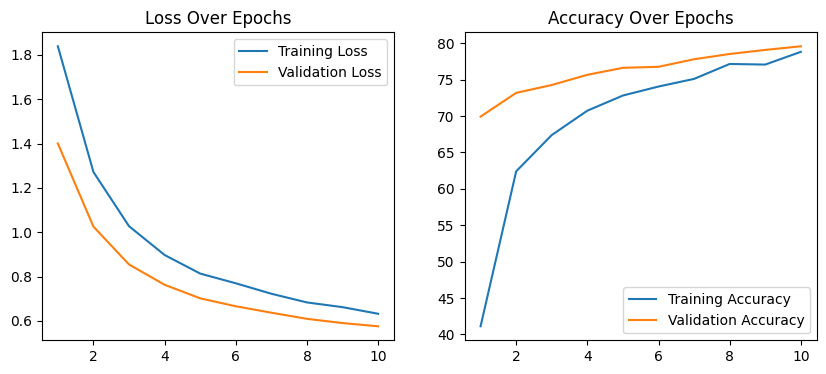

In [98]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 19. ¿Qué estrategias se pueden emplear para evitar el sobreajuste en redes neuronales convolucionales?

Respuesta: Para evitar el sobreajuste en CNNs, se pueden emplear técnicas como regularización (Dropout y L2), normalización (Batch Normalization), aumento de datos, early stopping, reducción de la complejidad del modelo, validación cruzada, uso de conjuntos de validación independientes y ensambles de modelos. Estas estrategias ayudan a mejorar la capacidad de generalización del modelo y a prevenir el ajuste excesivo a los datos de entrenamiento.

## 20. ¿Cómo afecta la inicialización de pesos al entrenamiento de una CNN y cuáles son algunas prácticas recomendadas?

Respuesta: Algunas prácticas recomendables serían:
Utilizar métodos de inicialización aleatoria basados en distribuciones específicas, considerar la transferencia de aprendizaje y experimentar con diferentes enfoques son prácticas recomendadas para lograr un rendimiento óptimo del modelo.

In [99]:
# Código de demostración con el ejemplo proporcionado (inicialize los parámetros de la red convolucional con el método que desee para las diferentes capas)

In [100]:
import torch.nn.init as init

class SimpleCNN_Xavier(nn.Module):
    def __init__(self):
        super(SimpleCNN_Xavier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 10)

        # Inicialización de pesos con el método de Xavier
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [101]:
model_xavier = SimpleCNN_Xavier()
model_xavier.train()
model_xavier.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_xavier.parameters(), lr=0.003)

In [102]:
train_losses_xavier = []
train_accuracy_xavier = []
test_losses_xavier = []
test_accuracy_xavier = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model_xavier, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model_xavier, device, test_loader)

    # Almacenamiento de métricas
    train_losses_xavier.append(train_loss)
    train_accuracy_xavier.append(train_acc)
    test_losses_xavier.append(test_loss)
    test_accuracy_xavier.append(test_acc)


Train Epoch: 1 	Loss: 2.263503 	Accuracy: 19.30%
Test set: Average loss: 2.1952, Accuracy: 1815/5000 (36.30%)
Train Epoch: 2 	Loss: 2.101471 	Accuracy: 42.58%
Test set: Average loss: 1.9813, Accuracy: 2495/5000 (49.90%)
Train Epoch: 3 	Loss: 1.776881 	Accuracy: 56.50%
Test set: Average loss: 1.5306, Accuracy: 3099/5000 (61.98%)
Train Epoch: 4 	Loss: 1.284352 	Accuracy: 65.15%
Test set: Average loss: 1.1026, Accuracy: 3296/5000 (65.92%)
Train Epoch: 5 	Loss: 0.978561 	Accuracy: 68.45%
Test set: Average loss: 0.9216, Accuracy: 3411/5000 (68.22%)
Train Epoch: 6 	Loss: 0.842378 	Accuracy: 71.32%
Test set: Average loss: 0.8308, Accuracy: 3566/5000 (71.32%)
Train Epoch: 7 	Loss: 0.767832 	Accuracy: 72.88%
Test set: Average loss: 0.8304, Accuracy: 3418/5000 (68.36%)
Train Epoch: 8 	Loss: 0.722081 	Accuracy: 73.92%
Test set: Average loss: 0.7446, Accuracy: 3644/5000 (72.88%)
Train Epoch: 9 	Loss: 0.687223 	Accuracy: 75.17%
Test set: Average loss: 0.7149, Accuracy: 3689/5000 (73.78%)
Train Epoc

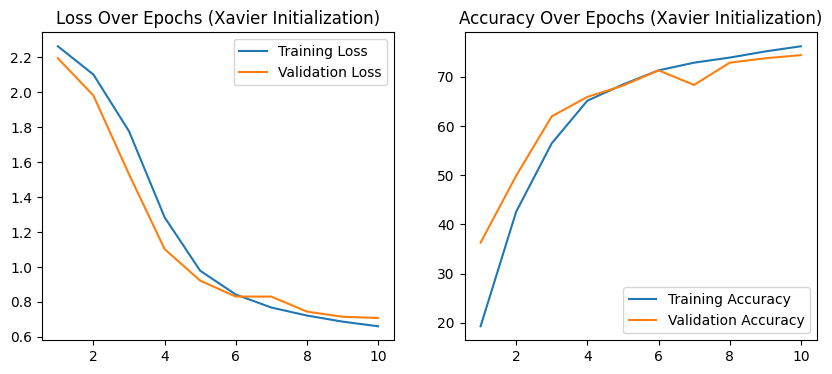

In [103]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses_xavier, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses_xavier, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs (Xavier Initialization)')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy_xavier, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy_xavier, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs (Xavier Initialization)')

plt.show()

## 21. ¿Cuál es el papel de las funciones de activación en una CNN y cómo la elección de una afecta al modelo?

Respuesta: ReLU es una opción común debido a su mitigación del problema de gradiente desvaneciente y su eficiencia en términos de cómputo. Sin embargo, dependiendo del problema y de las características del modelo, otras funciones de activación como sigmoides y tangentes hiperbólicas aún pueden ser útiles en ciertos contextos.

## 22. ¿Como afectan los diferentes tipos de optimizadores en el entrnemiento de una red convolucional?

Respuesta: La elección del optimizador depende del problema específico, la arquitectura del modelo y la disponibilidad de recursos computacionales. Adam y sus variantes como Nadam son opciones populares debido a su eficacia y adaptabilidad en una amplia gama de escenarios.

In [104]:
# Código de demostración con el ejemplo proporcionado (compare por ejemplo los resultados iniciales con ahora emplear optimizador ADAM)

In [105]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Capa convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Capa de pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Segunda capa convolucional
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Capa totalmente conectada
        self.fc2 = nn.Linear(120, 10)  # Capa de salida

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [106]:
model = SimpleCNN()
model.train()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [107]:
# Listas para almacenar las métricas
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

# Entrenamiento por 10 épocas
for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenar las métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 0.860634 	Accuracy: 68.02%
Test set: Average loss: 0.5666, Accuracy: 3963/5000 (79.26%)
Train Epoch: 2 	Loss: 0.481600 	Accuracy: 82.65%
Test set: Average loss: 0.4422, Accuracy: 4199/5000 (83.98%)
Train Epoch: 3 	Loss: 0.395108 	Accuracy: 85.72%
Test set: Average loss: 0.4170, Accuracy: 4246/5000 (84.92%)
Train Epoch: 4 	Loss: 0.332114 	Accuracy: 87.70%
Test set: Average loss: 0.4168, Accuracy: 4288/5000 (85.76%)
Train Epoch: 5 	Loss: 0.304516 	Accuracy: 88.90%
Test set: Average loss: 0.3925, Accuracy: 4311/5000 (86.22%)
Train Epoch: 6 	Loss: 0.272281 	Accuracy: 89.90%
Test set: Average loss: 0.3830, Accuracy: 4330/5000 (86.60%)
Train Epoch: 7 	Loss: 0.238890 	Accuracy: 91.18%
Test set: Average loss: 0.3942, Accuracy: 4328/5000 (86.56%)
Train Epoch: 8 	Loss: 0.202180 	Accuracy: 92.62%
Test set: Average loss: 0.4139, Accuracy: 4366/5000 (87.32%)
Train Epoch: 9 	Loss: 0.172392 	Accuracy: 93.33%
Test set: Average loss: 0.3850, Accuracy: 4333/5000 (86.66%)
Train Epoc

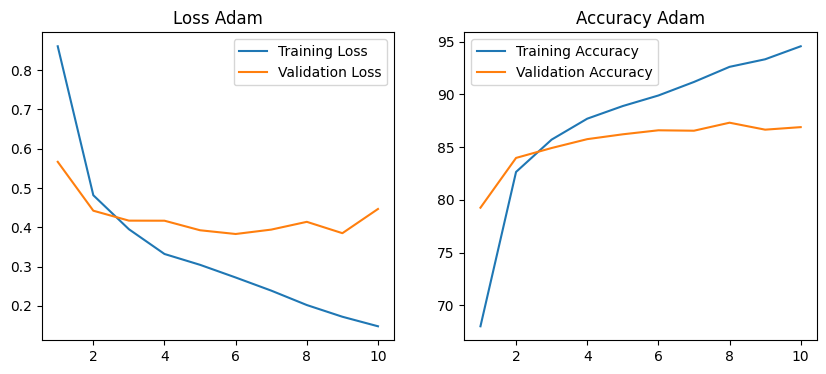

In [108]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Adam')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Adam')

plt.show()

## 23. ¿Cómo puede el aumento de datos (data augmentation) mejorar la generalización de una CNN?

Respuesta: El aumento de datos en una CNN aumenta la diversidad y cantidad de datos de entrenamiento, mejorando la robustez, previniendo el sobreajuste y actuando como una forma de regularización implícita, lo que lleva a una mejor generalización del modelo.

## 24. ¿Cuáles son las implicaciones de utilizar arquitecturas pre-entrenadas y transferencia de aprendizaje en CNNs?

Respuesta: Utilizar arquitecturas pre-entrenadas y transferencia de aprendizaje en CNNs permite aprovechar conocimientos previos, reducir el tiempo de entrenamiento, mejorar el rendimiento y adaptarse a nuevos dominios de datos de manera eficiente.

## 25. Discuta la importancia de la tasa de aprendizaje y las técnicas de ajuste de esta (como los schedulers de tasa de aprendizaje) en el entrenamiento efectivo de una CNN.

Respuesta: La tasa de aprendizaje y las técnicas de ajuste de esta son fundamentales para el entrenamiento efectivo de una CNN. Una tasa de aprendizaje adecuada y la aplicación de schedulers de tasa de aprendizaje pueden mejorar la convergencia, estabilidad y rendimiento del modelo, optimizando así el proceso de entrenamiento.

## 26. ¿De qué manera la elección del tamaño del batch afecta el entrenamiento de una CNN? Si trabaja con GPU, ¿qué limitaciones pueden aparecer con este parámetro?

Respuesta: Si bien los tamaños de batch más grandes pueden ser más eficientes, es importante equilibrar esto con las limitaciones de recursos de la GPU y los efectos en el rendimiento y la generalización del modelo.

# RNN

In [109]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(28, 64, batch_first=True)
        self.fc = nn.Linear(64, 10)  # Capa totalmente conectada para clasificación

    def forward(self, x):
        # x: batch_size, 28, 28
        x = x.view(-1, 28, 28)  # Tratar cada imagen como una secuencia de 28 filas
        _, (hidden, _) = self.lstm(x)  # LSTM devuelve hidden state y cell state, nos interesa hidden state
        hidden = hidden.view(-1, 64)  # Redimensionar el estado oculto para la capa lineal
        x = self.fc(hidden)
        return F.log_softmax(x, dim=1)

In [110]:
model = SimpleRNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

In [111]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 1.249103 	Accuracy: 54.12%
Test set: Average loss: 0.8712, Accuracy: 3394/5000 (67.88%)
Train Epoch: 2 	Loss: 0.726925 	Accuracy: 72.52%
Test set: Average loss: 0.6780, Accuracy: 3745/5000 (74.90%)
Train Epoch: 3 	Loss: 0.614614 	Accuracy: 77.70%
Test set: Average loss: 0.6218, Accuracy: 3876/5000 (77.52%)
Train Epoch: 4 	Loss: 0.539571 	Accuracy: 80.83%
Test set: Average loss: 0.6028, Accuracy: 3938/5000 (78.76%)
Train Epoch: 5 	Loss: 0.504613 	Accuracy: 82.02%
Test set: Average loss: 0.5634, Accuracy: 3973/5000 (79.46%)
Train Epoch: 6 	Loss: 0.471386 	Accuracy: 82.68%
Test set: Average loss: 0.5591, Accuracy: 4025/5000 (80.50%)
Train Epoch: 7 	Loss: 0.453219 	Accuracy: 83.25%
Test set: Average loss: 0.5332, Accuracy: 4018/5000 (80.36%)
Train Epoch: 8 	Loss: 0.446155 	Accuracy: 83.35%
Test set: Average loss: 0.5225, Accuracy: 4100/5000 (82.00%)
Train Epoch: 9 	Loss: 0.403215 	Accuracy: 85.22%
Test set: Average loss: 0.5180, Accuracy: 4107/5000 (82.14%)
Train Epoc

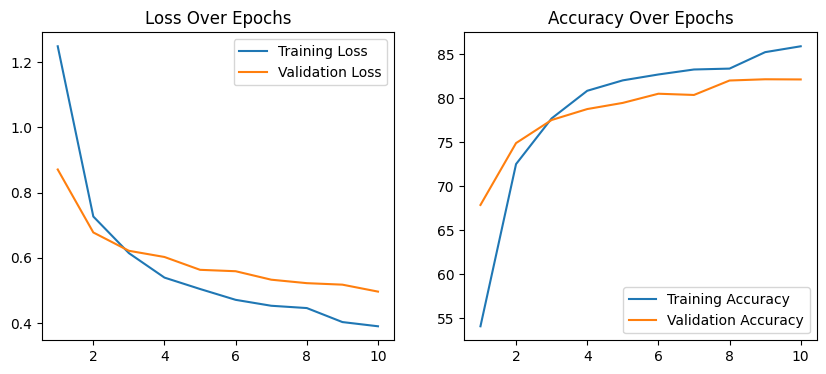

In [112]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 27. ¿Cómo afecta el número de unidades ocultas en una RNN al aprendizaje y la capacidad del modelo? Explore la relación entre la capacidad del modelo para capturar patrones complejos y el riesgo de overfitting.

Respuesta: El número de unidades ocultas en una RNN afecta tanto al aprendizaje del modelo como a su capacidad para capturar patrones complejos en los datos de secuencia. Es crucial encontrar un equilibrio entre la capacidad del modelo y la generalización para evitar el sobreajuste y obtener un rendimiento óptimo en una variedad de tareas de modelado de secuencias.

In [113]:
# Código de demostración con el ejemplo proporcionado (aumente y disminuya el tamaño de las unidades ocultas)

In [114]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(28, 128, batch_first=True)
        self.fc = nn.Linear(128, 10)  # Capa totalmente conectada para clasificación

    def forward(self, x):
        # x: batch_size, 28, 28
        x = x.view(-1, 28, 28)  # Tratar cada imagen como una secuencia de 28 filas
        _, (hidden, _) = self.lstm(x)  # LSTM devuelve hidden state y cell state, nos interesa hidden state
        hidden = hidden.view(-1, 128)  # Redimensionar el estado oculto para la capa lineal
        x = self.fc(hidden)
        return F.log_softmax(x, dim=1)

In [115]:
model = SimpleRNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

In [116]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 1.291081 	Accuracy: 52.10%
Test set: Average loss: 0.8847, Accuracy: 3270/5000 (65.40%)
Train Epoch: 2 	Loss: 0.770313 	Accuracy: 70.03%
Test set: Average loss: 0.8013, Accuracy: 3423/5000 (68.46%)
Train Epoch: 3 	Loss: 0.626491 	Accuracy: 76.23%
Test set: Average loss: 0.6550, Accuracy: 3771/5000 (75.42%)
Train Epoch: 4 	Loss: 0.554725 	Accuracy: 79.13%
Test set: Average loss: 0.5728, Accuracy: 3989/5000 (79.78%)
Train Epoch: 5 	Loss: 0.500702 	Accuracy: 81.87%
Test set: Average loss: 0.5387, Accuracy: 4033/5000 (80.66%)
Train Epoch: 6 	Loss: 0.467306 	Accuracy: 82.97%
Test set: Average loss: 0.5422, Accuracy: 3996/5000 (79.92%)
Train Epoch: 7 	Loss: 0.435534 	Accuracy: 83.90%
Test set: Average loss: 0.5216, Accuracy: 4068/5000 (81.36%)
Train Epoch: 8 	Loss: 0.417655 	Accuracy: 84.53%
Test set: Average loss: 0.4997, Accuracy: 4101/5000 (82.02%)
Train Epoch: 9 	Loss: 0.393716 	Accuracy: 85.23%
Test set: Average loss: 0.5381, Accuracy: 4038/5000 (80.76%)
Train Epoc

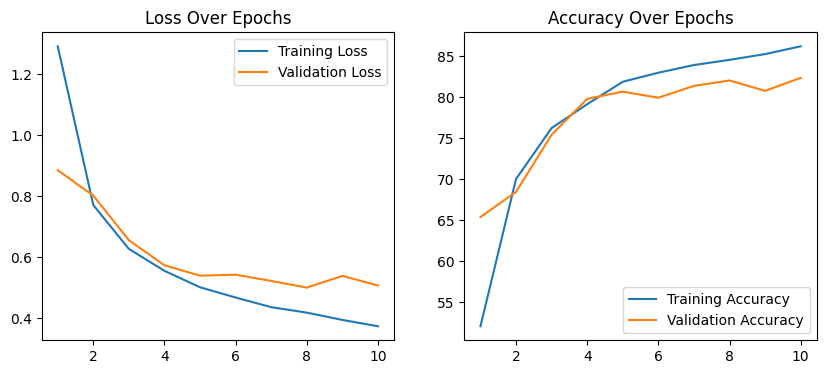

In [117]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [118]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(28, 32, batch_first=True)
        self.fc = nn.Linear(32, 10)  # Capa totalmente conectada para clasificación

    def forward(self, x):
        # x: batch_size, 28, 28
        x = x.view(-1, 28, 28)  # Tratar cada imagen como una secuencia de 28 filas
        _, (hidden, _) = self.lstm(x)  # LSTM devuelve hidden state y cell state, nos interesa hidden state
        hidden = hidden.view(-1, 32)  # Redimensionar el estado oculto para la capa lineal
        x = self.fc(hidden)
        return F.log_softmax(x, dim=1)

In [119]:
model = SimpleRNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

In [120]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 1.462984 	Accuracy: 48.67%
Test set: Average loss: 1.0797, Accuracy: 3138/5000 (62.76%)
Train Epoch: 2 	Loss: 0.897159 	Accuracy: 67.42%
Test set: Average loss: 0.8319, Accuracy: 3495/5000 (69.90%)
Train Epoch: 3 	Loss: 0.704181 	Accuracy: 74.08%
Test set: Average loss: 0.6920, Accuracy: 3772/5000 (75.44%)
Train Epoch: 4 	Loss: 0.634922 	Accuracy: 77.13%
Test set: Average loss: 0.6627, Accuracy: 3811/5000 (76.22%)
Train Epoch: 5 	Loss: 0.578423 	Accuracy: 79.40%
Test set: Average loss: 0.5990, Accuracy: 3960/5000 (79.20%)
Train Epoch: 6 	Loss: 0.534983 	Accuracy: 81.20%
Test set: Average loss: 0.5931, Accuracy: 3974/5000 (79.48%)
Train Epoch: 7 	Loss: 0.511167 	Accuracy: 81.48%
Test set: Average loss: 0.5807, Accuracy: 3967/5000 (79.34%)
Train Epoch: 8 	Loss: 0.467755 	Accuracy: 83.38%
Test set: Average loss: 0.5474, Accuracy: 4059/5000 (81.18%)
Train Epoch: 9 	Loss: 0.476946 	Accuracy: 82.78%
Test set: Average loss: 0.5569, Accuracy: 4022/5000 (80.44%)
Train Epoc

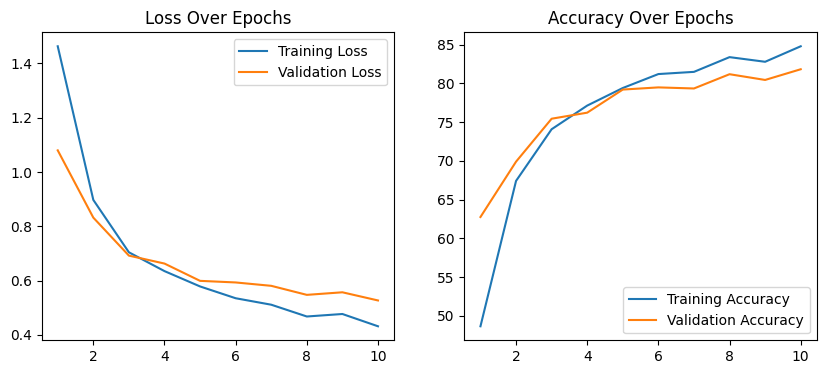

In [121]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 28. ¿Qué impacto tiene la longitud de la secuencia en el entrenamiento y rendimiento de una RNN? Discute cómo la longitud de las secuencias de entrada puede influir en la memoria a corto y largo plazo de la red.


Respuesta: La longitud de la secuencia en el entrenamiento y rendimiento de una RNN influye en su capacidad para capturar dependencias temporales tanto a corto como a largo plazo. Si bien las secuencias más largas pueden mejorar la memoria a largo plazo y la generalización, también pueden presentar desafíos computacionales y dificultades para mantener la información relevante a corto plazo durante el entrenamiento.

## 29. ¿Cómo se compara el uso de diferentes variantes de RNN (como LSTM y GRU) en términos de rendimiento y complejidad computacional? Investiga cómo las mejoras en la arquitectura de RNN pueden abordar problemas como la desaparición del gradiente o los gradientes explosivos.

Respuesta: LSTM y GRU ofrecen diferentes compromisos entre rendimiento y complejidad computacional. Mientras que LSTM es más poderoso en la captura de dependencias a largo plazo, GRU es más eficiente en términos computacionales. Ambas variantes están diseñadas para abordar problemas como la desaparición del gradiente y los gradientes explosivos, pero el rendimiento real puede depender de la tarea específica y del conjunto de datos.

In [122]:
# Código de demostración con el ejemplo proporcionado (cambie la red para usar celúlas de memoria GRU)

In [123]:
class SimpleGRU(nn.Module):
    def __init__(self):
        super(SimpleGRU, self).__init__()
        self.gru = nn.GRU(28, 64, batch_first=True)  # Cambiado a nn.GRU
        self.fc = nn.Linear(64, 10)  # Capa totalmente conectada para clasificación

    def forward(self, x):
        # x: batch_size, 28, 28
        x = x.view(-1, 28, 28)  # Tratar cada imagen como una secuencia de 28 filas
        _, hidden = self.gru(x)  # GRU devuelve hidden state
        hidden = hidden.view(-1, 64)  # Redimensionar el estado oculto para la capa lineal
        x = self.fc(hidden)
        return F.log_softmax(x, dim=1)


In [124]:
model = SimpleGRU().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

In [125]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 1.268754 	Accuracy: 53.70%
Test set: Average loss: 0.8157, Accuracy: 3542/5000 (70.84%)
Train Epoch: 2 	Loss: 0.714505 	Accuracy: 72.90%
Test set: Average loss: 0.6717, Accuracy: 3700/5000 (74.00%)
Train Epoch: 3 	Loss: 0.599488 	Accuracy: 77.67%
Test set: Average loss: 0.5930, Accuracy: 3885/5000 (77.70%)
Train Epoch: 4 	Loss: 0.533546 	Accuracy: 80.57%
Test set: Average loss: 0.5864, Accuracy: 3956/5000 (79.12%)
Train Epoch: 5 	Loss: 0.492223 	Accuracy: 82.15%
Test set: Average loss: 0.5109, Accuracy: 4122/5000 (82.44%)
Train Epoch: 6 	Loss: 0.441955 	Accuracy: 83.72%
Test set: Average loss: 0.4887, Accuracy: 4147/5000 (82.94%)
Train Epoch: 7 	Loss: 0.414135 	Accuracy: 85.25%
Test set: Average loss: 0.4869, Accuracy: 4123/5000 (82.46%)
Train Epoch: 8 	Loss: 0.387330 	Accuracy: 86.02%
Test set: Average loss: 0.4892, Accuracy: 4163/5000 (83.26%)
Train Epoch: 9 	Loss: 0.362527 	Accuracy: 86.58%
Test set: Average loss: 0.4779, Accuracy: 4154/5000 (83.08%)
Train Epoc

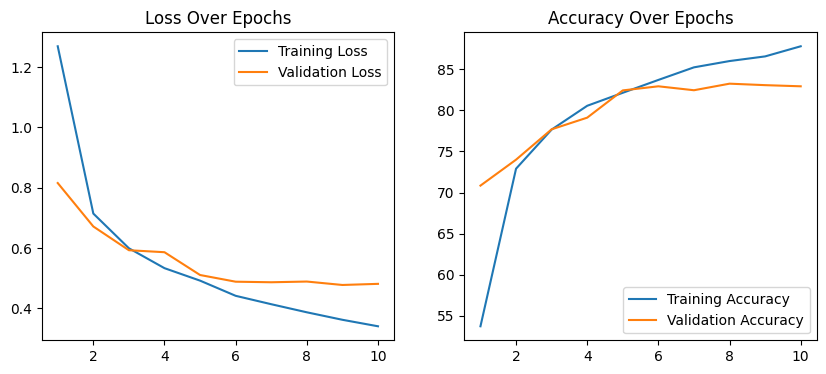

In [126]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

## 30. Discuta las diferencias en la aplicación y el rendimiento entre una RNN unidireccional y una RNN bidireccional. ¿Tiene sentido en este ejemplo?

Respuesta: La elección entre una RNN unidireccional y una RNN bidireccional depende de la naturaleza de la tarea y la importancia de la información contextual futura. Ambas tienen sus aplicaciones específicas y pueden ofrecer diferentes niveles de rendimiento en diferentes contextos.

In [127]:
# Código de demostración con el ejemplo proporcionado (implemente una red bidireccional recurrente y compare los resultados)

In [128]:
class BiRNN(nn.Module):
    def __init__(self):
        super(BiRNN, self).__init__()
        self.lstm = nn.LSTM(28, 64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128, 10)  # Capa totalmente conectada para clasificación

    def forward(self, x):
        # x: batch_size, 28, 28
        x = x.view(-1, 28, 28)  # Tratar cada imagen como una secuencia de 28 filas
        _, (hidden, _) = self.lstm(x)  # LSTM devuelve hidden state y cell state, nos interesa hidden state
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)  # Concatenar las salidas bidireccionales
        x = self.fc(hidden)
        return F.log_softmax(x, dim=1)


In [129]:
model = BiRNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

In [130]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

for epoch in range(1, 11):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = validate(model, device, test_loader)

    # Almacenamiento de métricas
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

Train Epoch: 1 	Loss: 1.060450 	Accuracy: 61.75%
Test set: Average loss: 0.7137, Accuracy: 3692/5000 (73.84%)
Train Epoch: 2 	Loss: 0.612085 	Accuracy: 77.25%
Test set: Average loss: 0.6070, Accuracy: 3933/5000 (78.66%)
Train Epoch: 3 	Loss: 0.533776 	Accuracy: 80.55%
Test set: Average loss: 0.5464, Accuracy: 4005/5000 (80.10%)
Train Epoch: 4 	Loss: 0.463677 	Accuracy: 83.40%
Test set: Average loss: 0.5079, Accuracy: 4089/5000 (81.78%)
Train Epoch: 5 	Loss: 0.430954 	Accuracy: 84.23%
Test set: Average loss: 0.5172, Accuracy: 4066/5000 (81.32%)
Train Epoch: 6 	Loss: 0.407710 	Accuracy: 85.03%
Test set: Average loss: 0.4665, Accuracy: 4169/5000 (83.38%)
Train Epoch: 7 	Loss: 0.383806 	Accuracy: 85.93%
Test set: Average loss: 0.4622, Accuracy: 4221/5000 (84.42%)
Train Epoch: 8 	Loss: 0.349296 	Accuracy: 87.17%
Test set: Average loss: 0.4594, Accuracy: 4209/5000 (84.18%)
Train Epoch: 9 	Loss: 0.342233 	Accuracy: 87.22%
Test set: Average loss: 0.4588, Accuracy: 4206/5000 (84.12%)
Train Epoc

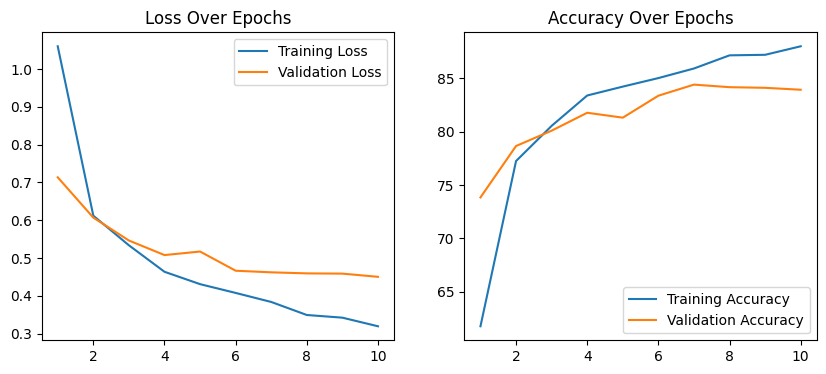

In [131]:
# Visualización de las métricas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, 11)), train_losses, label='Training Loss')
plt.plot(list(range(1, 11)), test_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(list(range(1, 11)), train_accuracy, label='Training Accuracy')
plt.plot(list(range(1, 11)), test_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()